# Imports

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from simulation import Simulation
from scipy.stats import lognorm
from scipy.special import i0
from analysis import calculate_autocorrelation, calculate_msd, fit_von_mises_mixture_mle, compute_turning_angles, compute_msd_dacf_per_movie

In [40]:
# # Set the style for Seaborn plots
# sns.set_theme(style="white", rc={"axes.labelsize": 22, "xtick.labelsize": 18, "ytick.labelsize": 18})
# sns.set_context("talk", font_scale=1.5)

# Get 4 distinct colors from Seaborn's Set2 palette
colors = sns.color_palette("colorblind", 4)

# Assign colors to each dataset
color_map = {
    "3D Manual Tracking": colors[1],
    "3D BTrack Tracking": colors[3], 
    "2D BTrack Tracking": colors[2],
    "NIH3T3": "grey",
    "Simulation": colors[0],
}

# Simulating without Experimental Data (Velocity and Turning Angles Distributions)

In [41]:
from simulation import Simulation
from visualization import plot_trajectories, create_animation, plot_cell_statistics
from analysis import calculate_autocorrelation, calculate_msd

# # Create simulation with proper stadium parameters
# sim = Simulation(
#     n_cells=50,
#     stadium_L=800,          # Length of straight walls
#     stadium_R=200,          # Radius of semicircles
#     source_length=400,      # Length of gradient line source
#     chemotaxis_strength=0.0,
#     repulsion_strength=0.2,
#     starting_positions='perimeter'
# )

# # Run simulation
# sim.run(n_steps=100)

# # Visualize
# plot_trajectories(sim)
# plot_cell_statistics(sim)

# load data and fit distributions

In [42]:
# Load data
isolated_cells_data = pd.read_csv(r'D:\David\THESIS\tracks_dataframes\tracks_df_2025_01_22_2DFACS_FOXA2positive_lateday2.csv')
patterned_cells_data = pd.read_csv(r'D:\David\THESIS\tracks_dataframes\tracks_df_2024_09_09_FoxA2_tdTom_c211to300_BmpAct_day2To3.csv')
NIH3T3_cells_data = pd.read_csv(r'D:\David\THESIS\tracks_dataframes\tracks_df_2025_09_30_NIH3T3_migration_on_laminin.csv')

minimum_track_length = 50 
data = patterned_cells_data[['file', 'track_id', 't', 'normalized_time', 'x_microns', 'y_microns']]
data = data.groupby('track_id').filter(lambda x: len(x) >= minimum_track_length)
data['step'] = data.groupby('track_id').cumcount()
data['dx'] = data.groupby('track_id')['x_microns'].diff()
data['dy'] = data.groupby('track_id')['y_microns'].diff()
data['theta'] = np.arctan2(data['dy'], data['dx'])
data['dt'] = 5
data['v_x'] = data['dx'] / data['dt']
data['v_y'] = data['dy'] / data['dt']
data['velocity'] = np.sqrt(data['dx']**2 + data['dy']**2)/data['dt']
data['velocity'] = data['velocity'].replace([np.inf, -np.inf], np.nan)

# Fit a log-normal distribution to the velocity data
velocity_data = data['velocity'].dropna().values
velocity_data = velocity_data[velocity_data > 0]
shape, loc, scale = lognorm.fit(velocity_data, floc=0)
print(f"Fitted log-normal parameters: shape={shape}, loc={loc}, scale={scale}")

# Fit von Mises mixture model to turning angles
turning_angles = compute_turning_angles(data)
vonmises_params = fit_von_mises_mixture_mle(turning_angles)
print(f"Fitted von Mises mixture parameters: {vonmises_params}")

tracks = [group[['x_microns', 'y_microns']].values 
          for _, group in data.groupby('track_id')]

Fitted log-normal parameters: shape=0.7700315866974897, loc=0, scale=0.2802353573838469
Fitted von Mises mixture parameters: {'params': {'W1': np.float64(0.7850139204062415), 'kappa1': np.float64(0.0), 'kappa2': np.float64(2.6542212269715684)}, 'success': True, 'message': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'nll': np.float64(97311.38894860668)}


Text(0, 0.5, 'Density')

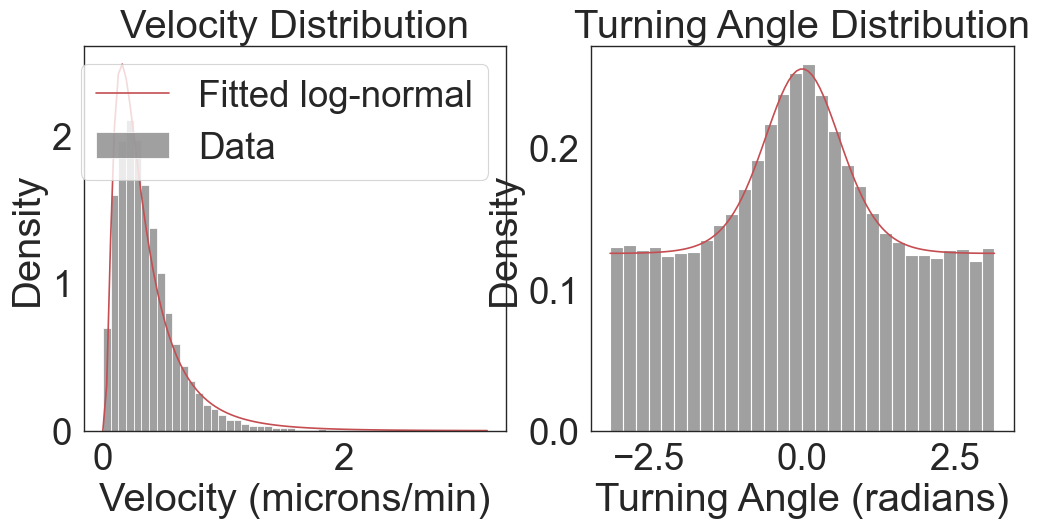

In [43]:
# plot one figure with velocity distribution and turning angle distribution and fitted curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Velocity distribution
sns.histplot(velocity_data, bins=50, kde=False, stat='density', ax=axes[0], color='gray', label='Data')
x = np.linspace(0, velocity_data.max(), 100)
pdf_fitted = lognorm.pdf(x, shape, loc=loc, scale=scale)
axes[0].plot(x, pdf_fitted, 'r-', label='Fitted log-normal')
axes[0].set_title('Velocity Distribution')
axes[0].set_xlabel('Velocity (microns/min)')
axes[0].set_ylabel('Density')
axes[0].legend()
# Turning angle distribution
sns.histplot(turning_angles, bins=30, kde=False, stat='density', ax=axes[1], color='gray', label='Data')
x_angles = np.linspace(-np.pi, np.pi, 100)
pdf_fitted_angles = (vonmises_params['params']['W1'] * 
                     (np.exp(vonmises_params['params']['kappa1'] * np.cos(x_angles)) / (2 * np.pi * i0(vonmises_params['params']['kappa1']))) +
                     (1 - vonmises_params['params']['W1']) * 
                     (np.exp(vonmises_params['params']['kappa2'] * np.cos(x_angles)) / (2 * np.pi * i0(vonmises_params['params']['kappa2']))))
axes[1].plot(x_angles, pdf_fitted_angles, 'r-', label='Fitted von Mises mixture')
axes[1].set_title('Turning Angle Distribution')
axes[1].set_xlabel('Turning Angle (radians)')
axes[1].set_ylabel('Density')

# Simulate

In [44]:
# Run simulation
sim = Simulation(
    n_cells=300,
    time_step=5, # time step in minutes
    stadium_L=800,
    stadium_R=200,
    source_length=400,
    chemotaxis_strength=0.3,
    repulsion_strength=0.0, # the default is no cell-cell repulsion
    interaction_radius=0.0, 
    velocity_params={'shape': shape, 'loc': loc, 'scale': scale}, # parameters of the log-normal distribution fitted to the data
    persistence=0.1,
    starting_positions='perimeter', # Initial positions distribution for cells: 'perimeter' or 'uniform'
    mode='biased_persistent', # Simulation mode: 'random', 'persistent', 'biased_persistent', 'uniform_memory', 'exp_memory', 'power_memory'
    # Memory parameters (only used if mode is 'uniform_memory', 'exp_memory', or 'power_memory')
    memory_window=None, 
    memory_exp_lambda=0.1,
    memory_power_alpha=1.5, # power-law exponent for power_memory mode
    vonmises_params=vonmises_params['params'])

sim.run(n_steps=data['step'].max())
sim_df = sim.get_dataframe()

Step 25/288 completed
Step 50/288 completed
Step 75/288 completed
Step 100/288 completed
Step 125/288 completed
Step 150/288 completed
Step 175/288 completed
Step 200/288 completed
Step 225/288 completed
Step 250/288 completed
Step 275/288 completed
Simulation completed: 288 steps


In [45]:
from visualization import plot_trajectories, create_animation, plot_cell_statistics

# Plot trajectories
# plot_trajectories(sim, show_gradient=False)

# # Create animation
# anim = create_animation(sim, save_path='migration.gif')

# Plot statistics
# plot_cell_statistics(sim)

In [46]:
msd_exp, dacf_exp = compute_msd_dacf_per_movie(data, x_col='x_microns', y_col='y_microns', max_lag=None)

msd_sim, dacf_sim = calculate_msd(sim_df, x_col='x', y_col='y'), calculate_autocorrelation(sim_df)

# Fit

In [47]:
# from fit import fit_grid

exp_df = patterned_cells_data.copy()
exp_df = exp_df.groupby('track_id').filter(lambda x: len(x) >= minimum_track_length)
exp_df['step'] = exp_df.groupby('track_id').cumcount()
exp_df['dx'] = exp_df.groupby('track_id')['x_microns'].diff()
exp_df['dy'] = exp_df.groupby('track_id')['y_microns'].diff()
exp_df['velocity'] = np.sqrt(exp_df['dx']**2 + exp_df['dy']**2)/5  # Assuming dt=10 as in experimental data
exp_df['v_x'] = exp_df['dx'] / 5
exp_df['v_y'] = exp_df['dy'] / 5
exp_df['x'] = exp_df['x_microns']
exp_df['y'] = exp_df['y_microns']

# fit velocity distribution
velocity_data = exp_df['velocity'].dropna().values
velocity_data = velocity_data[velocity_data > 0]
shape, loc, scale = lognorm.fit(velocity_data, floc=0)

# # Define parameter grid for fitting
# params_grid = {
#     'memory_power_alpha': np.linspace(0.3, 2, 3),
#     # 'memory_exp_lambda': np.linspace(0.01, 0.5, 10),
#     'memory_window': [5, 10],
#     'chemotaxis_strength': [0.2]
# }

# # options for simulation_mode: 'random', 'persistent', 'biased_persistent', 'uniform_memory', 'exp_memory', 'power_memory', 'persistent_chemotaxis'
# best, table = fit_grid(exp_df,
#                        simulation_mode='power_memory',
#                        param_grid=params_grid,
#                        velocity_dist_params={'shape': shape, 'loc': loc, 'scale': scale},
#                        vonmises_params=vonmises_params['params'],
#                        chi_weight=0.5,
#                        n_steps=289,
#                        n_cells=200)

# print("Best parameters:", best)

In [48]:
# tbl = table.copy()
# tbl['memory_power_alpha'] = tbl['memory_power_alpha'].round(2)
# tbl['memory_window'] = tbl['memory_window'].round(2)
# tbl['chemotaxis_strength'] = tbl['chemotaxis_strength'].round(2)

In [49]:
# # round persistence and chemotaxis_strength to 2 decimals and plot heatmaps

# # CHOOSE SUBSET OF POWER ALPHA AND MEMORY WINDOW
# tbl = tbl[(tbl['memory_power_alpha'].between(1.3, 2.0)) &
#           (tbl['memory_window'].between(5, 300))]
# tbl['memory_power_alpha'] = tbl['memory_power_alpha'].round(2)
# tbl['memory_window'] = tbl['memory_window'].round(2)

# # log scale
# # tbl['chi2_dacf'] = np.log(tbl['chi2_dacf'])
# # tbl['chi2_msd'] = np.log(tbl['chi2_msd'])
# # tbl['score'] = np.log(tbl['score'])

# # log scale heatmaps
# fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# # Big title
# # plt.suptitle('Log Scale Heatmaps of Chi-squared Values', fontsize=25)

# sns.heatmap(table_pivot_dacf, ax=axes[0], cmap='viridis', annot=False, fmt='.2f')
# axes[0].set_title('Chi-squared DACF')
# axes[0].set_xlabel('Memory Window')
# axes[0].set_ylabel('Memory Exp Lambda')
# axes[0].set_xticks(np.arange(len(table_pivot_dacf.columns)) + 0.5)
# axes[0].set_xticklabels([f"{c:.2f}" for c in table_pivot_dacf.columns], rotation=90, fontsize=16)
# axes[0].set_yticks(np.arange(len(table_pivot_dacf.index)) + 0.5)
# axes[0].set_yticklabels([f"{i:.2f}" for i in table_pivot_dacf.index], rotation=0, fontsize=16)

# sns.heatmap(table_pivot_msd, ax=axes[1], cmap='viridis', annot=False, fmt='.2f')
# axes[1].set_title('Chi-squared MSD')
# axes[1].set_xlabel('Memory Window')
# axes[1].set_ylabel('')
# axes[1].set_xticks(np.arange(len(table_pivot_msd.columns)) + 0.5)
# axes[1].set_xticklabels([f"{c:.2f}" for c in table_pivot_msd.columns], rotation=90, fontsize=16)
# axes[1].set_yticks(np.arange(len(table_pivot_msd.index)) + 0.5)
# axes[1].set_yticklabels([])

# sns.heatmap(table_pivot_total, ax=axes[2], cmap='viridis', annot=False, fmt='.2f')
# axes[2].set_title('Total Chi-squared')
# axes[2].set_xlabel('Memory Window')
# axes[2].set_ylabel('')
# axes[2].set_xticks(np.arange(len(table_pivot_total.columns)) + 0.5)
# axes[2].set_xticklabels([f"{c:.2f}" for c in table_pivot_total.columns], rotation=90, fontsize=16)
# axes[2].set_yticks(np.arange(len(table_pivot_total.index)) + 0.5)
# axes[2].set_yticklabels([])

# plt.tight_layout()
# plt.show()

In [50]:
# tbl['persistence'] = tbl['persistence'].round(2)

# # plot chi as a function of persistence
# fig, ax = plt.subplots(figsize=(8, 8))
# sns.lineplot(data=tbl, x='persistence', y='chi2_dacf', marker='o', ax=ax, label='Chi-squared DACF', linewidth=2)
# sns.lineplot(data=tbl, x='persistence', y='chi2_msd', marker='o', ax=ax, color='orange', label='Chi-squared MSD', linewidth=2)
# plt.xlabel('Persistence')
# plt.ylabel('Chi-squared Score')
# plt.legend()
# ax.set_title('Chi-squared Score vs Persistence')

In [51]:
# # plot the chi-squared values for chemotaxis_strength=0.0 as a function of persistence
# chemotaxis_fixed = 0.0
# subset = tbl[tbl['chemotaxis_strength'] == chemotaxis_fixed]
# subset = subset.sort_values(by='persistence')
# plt.figure(figsize=(8, 6))
# # plt.scatter(subset['persistence'][:-1], subset['chi2_dacf'][:-1], marker='o', label='Chi-squared DACF', color='blue')
# # plt.scatter(subset['persistence'][:-1], subset['chi2_msd'][:-1], marker='o', label='Chi-squared MSD', color='orange')
# plt.plot(subset['persistence'][:-1], subset['score'][:-1], marker='o', label='Total Score', color='k', markersize=8, linewidth=3)
# plt.ylim(0, 20.5)
# plt.xlabel('Persistence')
# plt.ylabel('Chi-squared Value')

In [86]:
# plot best simulation vs experimental data
best_sim = Simulation(
    n_cells=200,
    time_step=5, # time step in minutes
    stadium_L=800,
    stadium_R=200,
    source_length=400,
    chemotaxis_strength=0.2,
    repulsion_strength=0.0, # the default is no cell-cell repulsion
    interaction_radius=0.0, 
    velocity_params={'shape': shape, 'loc': loc, 'scale': scale}, # parameters of the log-normal distribution fitted to the data
    persistence=None,
    starting_positions='perimeter', # Initial positions distribution for cells: 'perimeter' or 'uniform'
    mode='power_memory', # Simulation mode: 'random', 'persistent', 'biased_persistent', 'uniform_memory', 'exp_memory', 'power_memory'
    # Memory parameters (only used if mode is 'uniform_memory', 'exp_memory', or 'power_memory')
    memory_window=280,
    memory_exp_lambda=0.0, 
    memory_power_alpha=0.9, # power-law exponent for power_memory mode
    vonmises_params=vonmises_params['params'])

best_sim.run(n_steps=289)
best_sim_df = best_sim.get_dataframe()

Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps


In [53]:
# Plot trajectories
# plot_trajectories(best_sim, show_gradient=False)

# # Create animation
# anim = create_animation(best_sim, save_path='migration.gif')

# Plot statistics
# plot_cell_statistics(best_sim)

In [87]:
msd_exp, dacf_exp = compute_msd_dacf_per_movie(exp_df, max_lag=None)

best_sim_dacf = calculate_autocorrelation(best_sim_df)
best_sim_msd = calculate_msd(best_sim_df, x_col='x', y_col='y')

In [55]:
# fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# # DACF plot
# n_memory = 10  # Number of memory steps 
# axes[0].scatter(dacf_exp['lag'], dacf_exp['dacf_mean'], label='Experiment', color=color_map["2D BTrack Tracking"], marker='o')
# axes[0].scatter(best_sim_dacf['lag'][:n_memory], best_sim_dacf['dacf_mean'][:n_memory], label='Simulation (memory)', color='red', marker='o')
# axes[0].scatter(best_sim_dacf['lag'][n_memory:], best_sim_dacf['dacf_mean'][n_memory:], label='Simulation (guess)', facecolors='none', edgecolors='red', marker='o')
# axes[0].set_xscale('log')
# axes[0].set_yscale('log')
# axes[0].set_xlabel('Lag')
# axes[0].set_ylabel('DACF')
# axes[0].set_title('Directional Autocorrelation')
# axes[0].legend()

# # MSD plot
# axes[1].scatter(msd_exp['lag'], msd_exp['msd_mean'], label='Experiment', color=color_map["2D BTrack Tracking"], marker='o')
# axes[1].scatter(best_sim_msd['lag'][:n_memory], best_sim_msd['msd_mean'][:n_memory], label='Simulation (memory)', color='red', marker='o')
# axes[1].scatter(best_sim_msd['lag'][n_memory:], best_sim_msd['msd_mean'][n_memory:], label='Simulation (guess)', facecolors='none', edgecolors='red', marker='o')
# axes[1].set_xscale('log')
# axes[1].set_yscale('log')
# axes[1].grid(True, which='major', linestyle='--', linewidth=0.5)
# axes[1].set_xlabel('Lag')
# axes[1].set_ylabel('MSD')
# axes[1].set_title('Mean Squared Displacement')
# axes[1].legend()

# plt.tight_layout()
# plt.show()

In [56]:
# Set the style for Seaborn plots
sns.set_theme(style="white", rc={"axes.labelsize": 22, "xtick.labelsize": 18, "ytick.labelsize": 18})
sns.set_context("paper", font_scale=3)

Chi-squared DACF: 7.9858
Chi-squared MSD: 1.7472


C:\Users\davidzi\AppData\Local\Temp\ipykernel_95900\1222982506.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


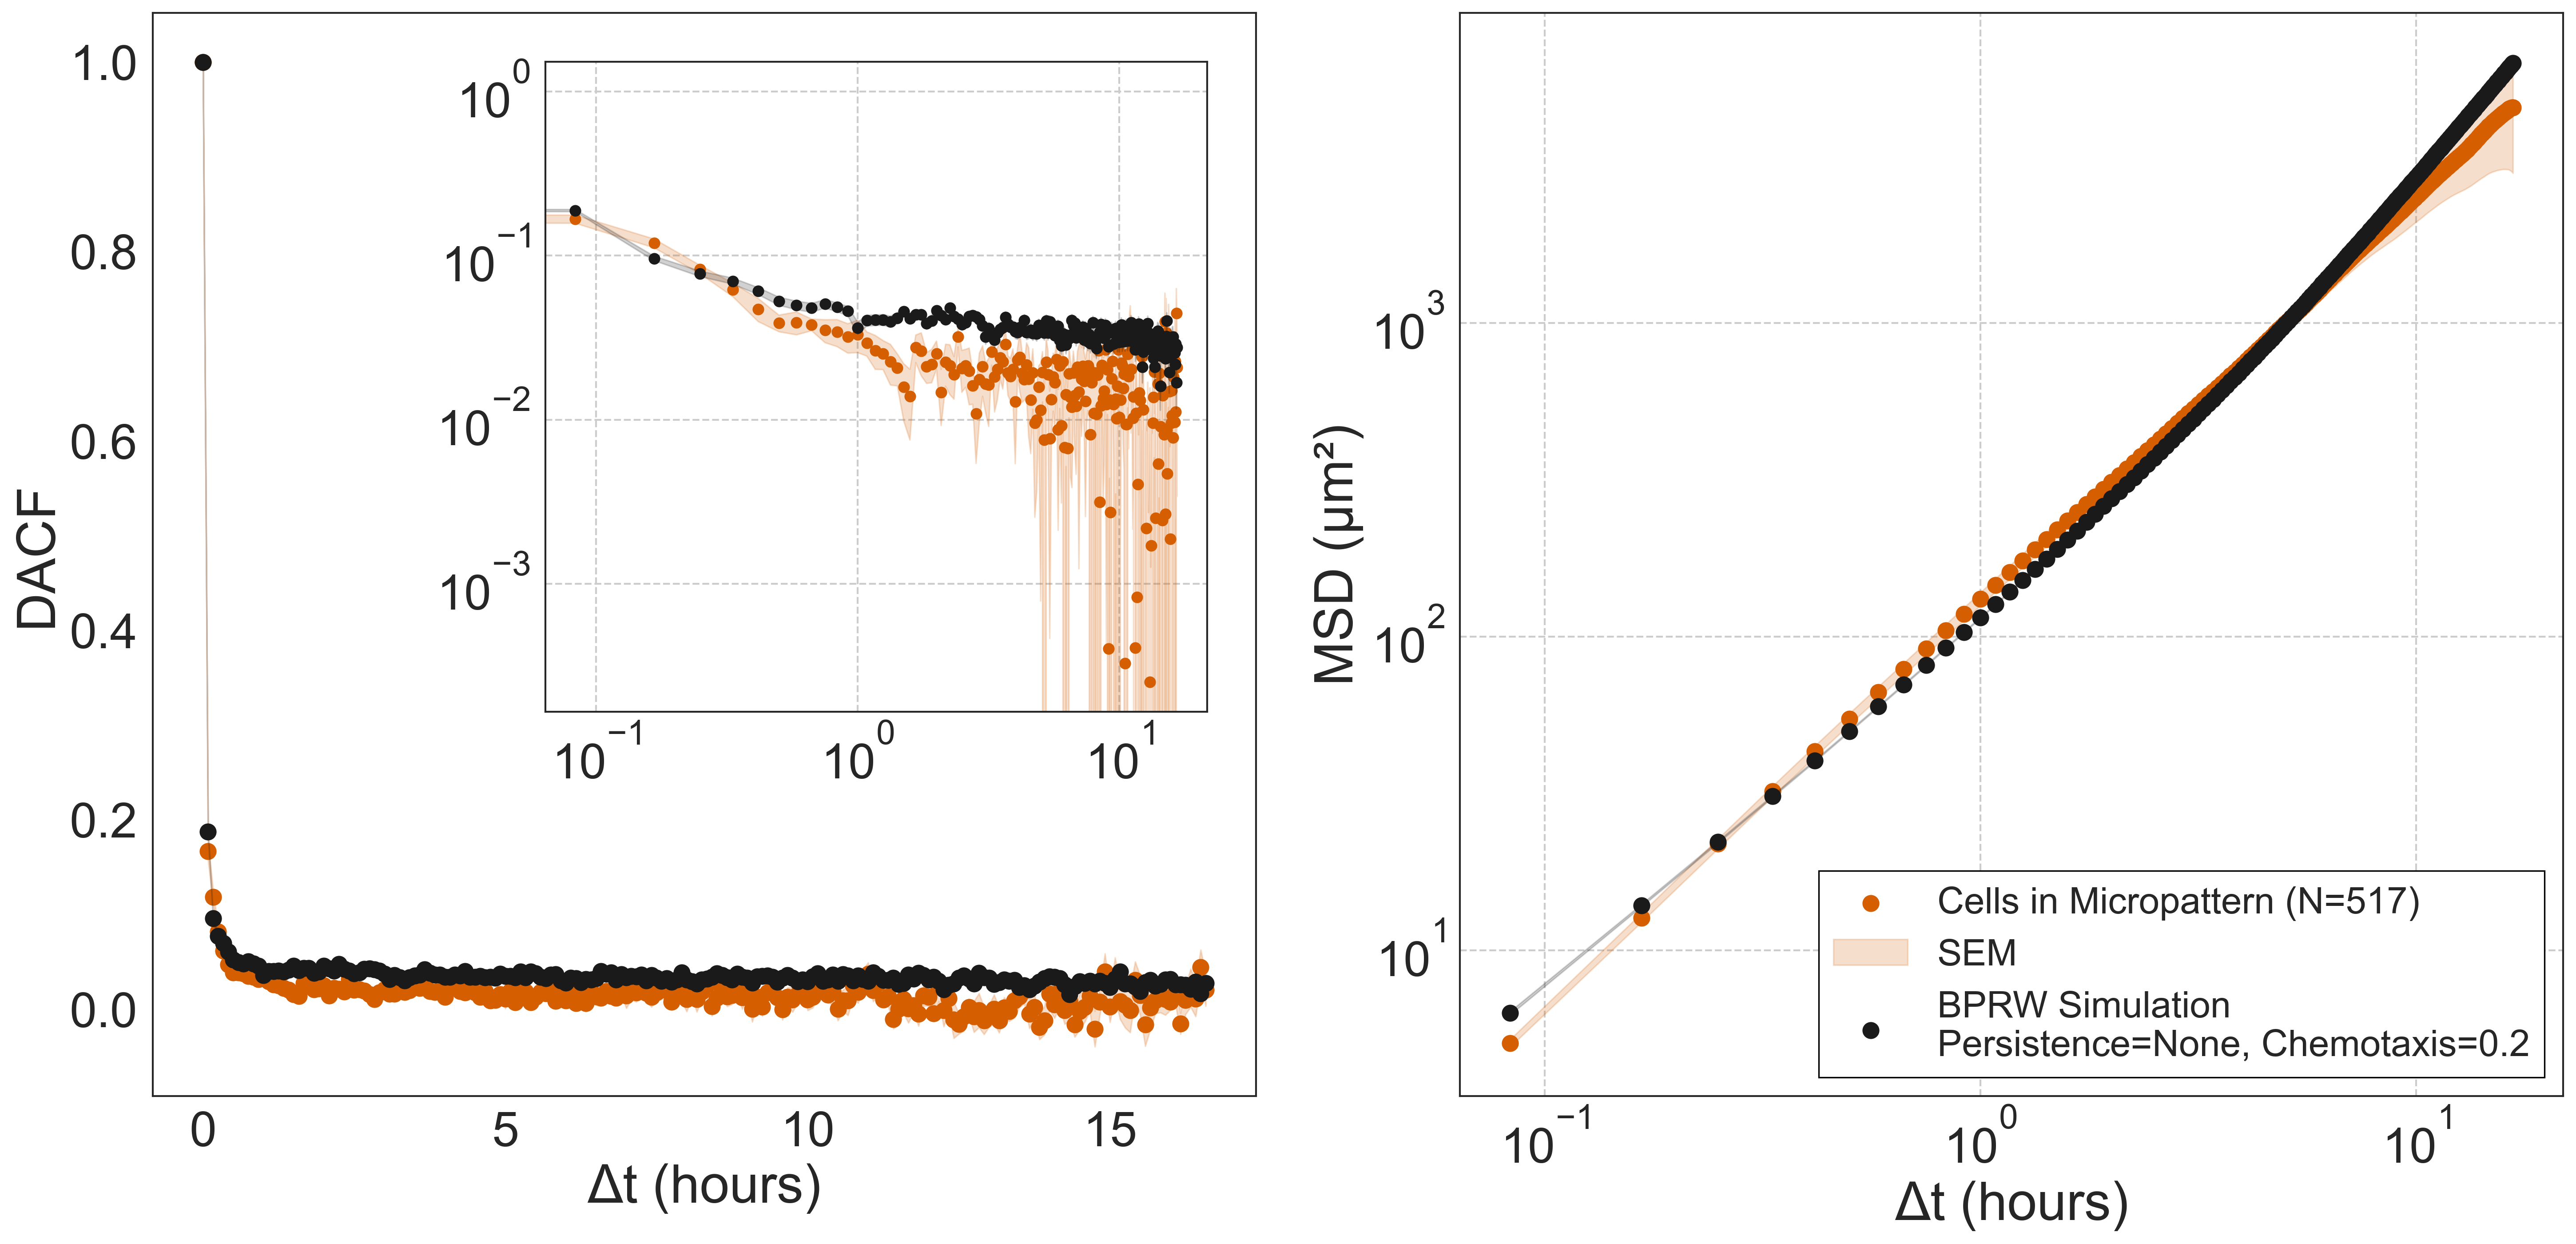

In [88]:
# calculate chi squared values for DACF and MSD
from fit import reduced_chi_squared
chi2_dacf = reduced_chi_squared(dacf_exp['dacf_mean'][:20], best_sim_dacf['dacf'][:20], dacf_exp['dacf_sem'][:20])
chi2_msd = reduced_chi_squared(msd_exp['msd_mean'][:200], best_sim_msd['msd'][:200], msd_exp['msd_sem'][:200])
print(f"Chi-squared DACF: {chi2_dacf:.4f}")
print(f"Chi-squared MSD: {chi2_msd:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(20, 10), dpi=300)

points_to_plot = 200  # Number of points to plot for DACF and MSD
color = color_map['3D BTrack Tracking']
simulation_label = f'BPRW Simulation' + '\n' + f'Persistence={best_sim.persistence}, Chemotaxis={best_sim.chemotaxis_strength}'
data_label = f'Cells in Micropattern (N={data["track_id"].nunique()})'

# Convert dt from minutes to hours for plotting (use same slicing as points_to_plot)
dacf_dt_hours = dacf_exp['dt'][:points_to_plot] / 60.0
best_sim_dacf_dt_hours = best_sim_dacf['dt'][:points_to_plot] / 60.0
msd_dt_hours = msd_exp['dt'][:points_to_plot] / 60.0
best_sim_msd_dt_hours = best_sim_msd['dt'][:points_to_plot] / 60.0

#
axes[0].scatter(dacf_dt_hours, dacf_exp['dacf_mean'][:points_to_plot], label=data_label, color=color, marker='o', s=70)
axes[0].fill_between(dacf_dt_hours,
                     dacf_exp['dacf_mean'][:points_to_plot] - dacf_exp['dacf_sem'][:points_to_plot],
                     dacf_exp['dacf_mean'][:points_to_plot] + dacf_exp['dacf_sem'][:points_to_plot],
                     color=color, alpha=0.2, label='SEM')
axes[0].scatter(best_sim_dacf_dt_hours, best_sim_dacf['dacf'][:points_to_plot], label=simulation_label, color='k', marker='o', s=70)
axes[0].fill_between(best_sim_dacf_dt_hours,
                     best_sim_dacf['dacf'][:points_to_plot] - best_sim_dacf['dacf_sem'][:points_to_plot],
                     best_sim_dacf['dacf'][:points_to_plot] + best_sim_dacf['dacf_sem'][:points_to_plot],
                     color='k', alpha=0.2)
# axes[0].set_xscale('log')
# axes[0].set_yscale('log')
# axes[0].grid(True, which='major', linestyle='--', linewidth=1)
axes[0].set_xlabel('Δt (hours)')
axes[0].set_ylabel('DACF')
# axes[0].set_title('Directional Autocorrelation')
# axes[0].legend(loc='upper right', frameon=1, fontsize=23, edgecolor='black', fancybox=False, framealpha=1)

# Add inset to DACF plot to show loglog
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(axes[0], width="60%", height="60%", loc='upper right', borderpad=1)
axins.scatter(dacf_dt_hours, dacf_exp['dacf_mean'][:points_to_plot], label=data_label, color=color, marker='o', s=30)
axins.fill_between(dacf_dt_hours,
                   dacf_exp['dacf_mean'][:points_to_plot] - dacf_exp['dacf_sem'][:points_to_plot],
                   dacf_exp['dacf_mean'][:points_to_plot] + dacf_exp['dacf_sem'][:points_to_plot],
                   color=color, alpha=0.2, label='SEM')
axins.scatter(best_sim_dacf_dt_hours, best_sim_dacf['dacf'][:points_to_plot], label=simulation_label, color='k', marker='o', s=30)
axins.fill_between(best_sim_dacf_dt_hours,
                   best_sim_dacf['dacf'][:points_to_plot] - best_sim_dacf['dacf_sem'][:points_to_plot],
                   best_sim_dacf['dacf'][:points_to_plot] + best_sim_dacf['dacf_sem'][:points_to_plot],
                   color='k', alpha=0.2)
axins.grid(True, which='major', linestyle='--', linewidth=1)
axins.set_xscale('log')
axins.set_yscale('log')

# MSD plot (x axis in hours now)
axes[1].scatter(msd_dt_hours, msd_exp['msd_mean'][:points_to_plot], label=data_label, color=color, marker='o', s=70)
# plot standard error of the mean as shaded area
axes[1].fill_between(msd_dt_hours,
                     msd_exp['msd_mean'][:points_to_plot] - msd_exp['msd_sem'][:points_to_plot],
                     msd_exp['msd_mean'][:points_to_plot] + msd_exp['msd_sem'][:points_to_plot],
                     color=color, alpha=0.2, label='SEM')
axes[1].scatter(best_sim_msd_dt_hours, best_sim_msd['msd'][:points_to_plot], label=simulation_label, color='k', marker='o', s=70)
axes[1].fill_between(best_sim_msd_dt_hours,
                     best_sim_msd['msd'][:points_to_plot] - best_sim_msd['msd_sem'][:points_to_plot],
                     best_sim_msd['msd'][:points_to_plot] + best_sim_msd['msd_sem'][:points_to_plot],
                     color='k', alpha=0.2)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True, which='major', linestyle='--', linewidth=1)
axes[1].set_xlabel('Δt (hours)')
axes[1].set_ylabel('MSD (μm²)')
# axes[1].set_title('Mean Squared Displacement')
axes[1].legend(loc='lower right', frameon=True, fontsize=20, edgecolor='black', fancybox=False, framealpha=1)

# legend below plots
# Move legend below the plots, outside the axes
handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=3, frameon=True, fontsize=24, edgecolor='black', fancybox=False, framealpha=1, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()

# Fit Memory

In [ ]:
n_cells = 200
n_steps = 289
time_step = 5
memory_power_alpha = 1

# Power-law memory sweep: vary memory_window and compare DACF/MSD to experimental (exp_df)
memory_windows_hours = [1/12, 1, 2, 4, 8]  # None means infinite memory
memory_windows = [int(w * 60 / time_step) for w in memory_windows_hours]
# memory_windows = np.linspace(1, 289, 101, dtype=int).tolist() + [n_steps]

results = {}
for w in memory_windows:
    sim_w = Simulation(
        n_cells=n_cells,
        time_step=time_step,
        stadium_L=8000,
        stadium_R=2000,
        source_length=400,
        chemotaxis_strength=0.0,
        repulsion_strength=0.0,
        interaction_radius=0.0,
        velocity_params={'shape': shape, 'loc': loc, 'scale': scale},
        persistence=0.0,
        starting_positions='uniform',
        mode='power_memory',
        memory_window=w,
        memory_exp_lambda=0.1,
        memory_power_alpha=memory_power_alpha,
        vonmises_params=vonmises_params['params']
    )
    sim_w.run(n_steps=n_steps)
    sim_df_w = sim_w.get_dataframe()
    msd_w = calculate_msd(sim_df_w, x_col='x', y_col='y')
    dacf_w = calculate_autocorrelation(sim_df_w)
    results[w] = {'sim': sim_w, 'df': sim_df_w, 'msd': msd_w, 'dacf': dacf_w}


Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps
Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps
Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps
Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 comple

C:\Users\davidzi\AppData\Local\Temp\ipykernel_95900\2980051340.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.3, 1, 1])  # leave space for both


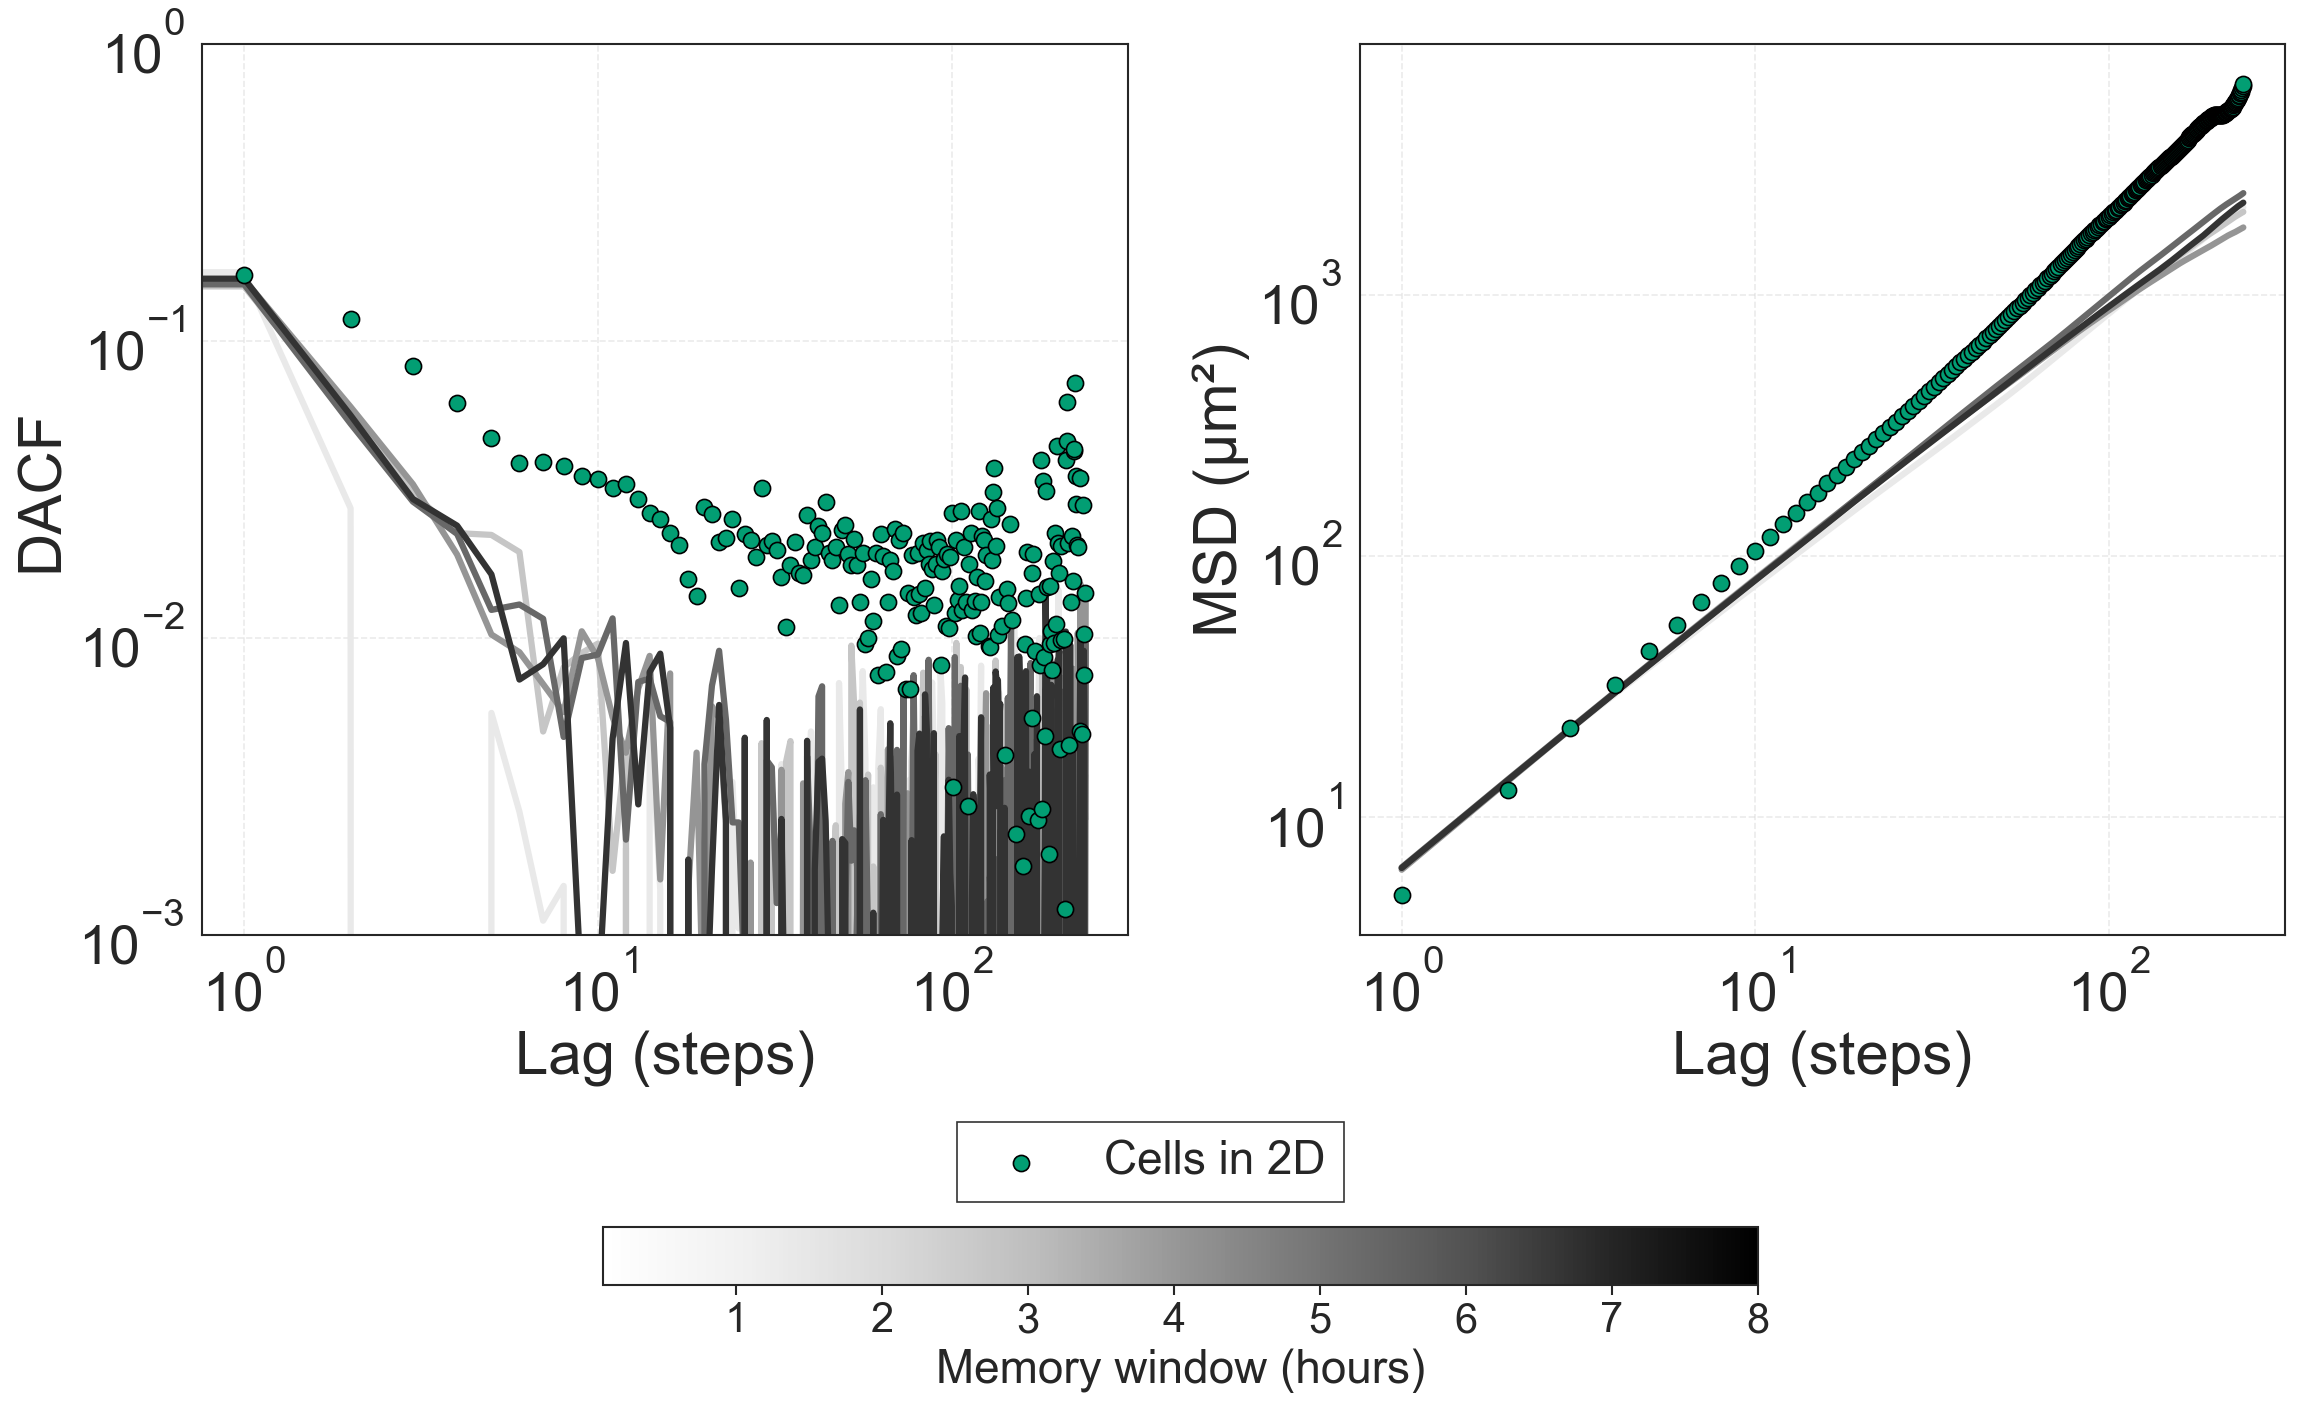

In [59]:
import matplotlib as mpl

points_to_plot = 240  # number of points to show for clarity
palette = sns.color_palette("Greys", len(memory_windows))

fig, axes = plt.subplots(1, 2, figsize=(16, 10), dpi=150)

# =========================================================
# DACF plot
# =========================================================
axes[0].scatter(dacf_exp['lag'][:points_to_plot], dacf_exp['dacf_mean'][:points_to_plot],
                label='Cells in 2D', color=color_map["2D BTrack Tracking"], s=60, zorder=3, edgecolor='black')

for i, w in enumerate(memory_windows):
    d = results[w]['dacf']
    axes[0].plot(d['lag'][:points_to_plot], d['dacf'][:points_to_plot],
                 color=palette[i], linewidth=3, zorder=2)

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_ylim(1e-3, 1)   
axes[0].set_xlabel('Lag (steps)')
axes[0].set_ylabel('DACF')
# axes[0].set_title('Directional Autocorrelation — effect of memory window')
axes[0].grid(True, linestyle='--', alpha=0.4)
# axes[0].legend(['FACSed DE on laminin'], loc='lower left', frameon=True, fontsize=20, edgecolor='black', fancybox=False, framealpha=1)

# =========================================================
# MSD plot
# =========================================================
axes[1].scatter(msd_exp['lag'][:points_to_plot], msd_exp['msd_mean'][:points_to_plot],
                label='FACSed DE on laminin', color=color_map["2D BTrack Tracking"], s=60, zorder=3, edgecolor='black')

for i, w in enumerate(memory_windows):
    m = results[w]['msd']
    axes[1].plot(m['lag'][:points_to_plot], m['msd'][:points_to_plot],
                 color=palette[i], linewidth=3, zorder=2)

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Lag (steps)')
axes[1].set_ylabel('MSD (μm²)')
# axes[1].set_title('Mean Squared Displacement — effect of memory window')
axes[1].grid(True, linestyle='--', alpha=0.4)
# axes[1].legend(['FACSed DE on laminin'], loc='lower left', frameon=True, fontsize=20, edgecolor='black', fancybox=False, framealpha=1)

# =========================================================
# Shared colorbar for memory window values
# =========================================================
# Create a ScalarMappable for colorbar
memory_windows_arr = np.array(memory_windows)
norm = mpl.colors.Normalize(vmin=min(memory_windows_arr/12), vmax=max(memory_windows_arr/12)) # normalize to hours assuming 1 step = 5 minutes
sm = mpl.cm.ScalarMappable(cmap=mpl.cm.Greys, norm=norm)
sm.set_array([])

# --- Legend: place above colorbar ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.15),  # move legend upward
    ncol=len(labels),            # horizontal layout
    fontsize=22,
    frameon=True,
    edgecolor='black',
    fancybox=False,
)

# --- Colorbar: move a bit lower ---
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal',
                    fraction=0.05, pad=0.25)  # pad increases distance from plots
cbar.set_label('Memory window (hours)', fontsize=22)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout(rect=[0, 0.3, 1, 1])  # leave space for both
plt.show()

Note: memory window 1: 1 zero-lag points skipped for log-x.
Note: memory window 12: 1 zero-lag points skipped for log-x.
Note: memory window 24: 1 zero-lag points skipped for log-x.
Note: memory window 48: 1 zero-lag points skipped for log-x.
Note: memory window 96: 1 zero-lag points skipped for log-x.


C:\Users\davidzi\AppData\Local\Temp\ipykernel_95900\434295445.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.3, 1, 1])


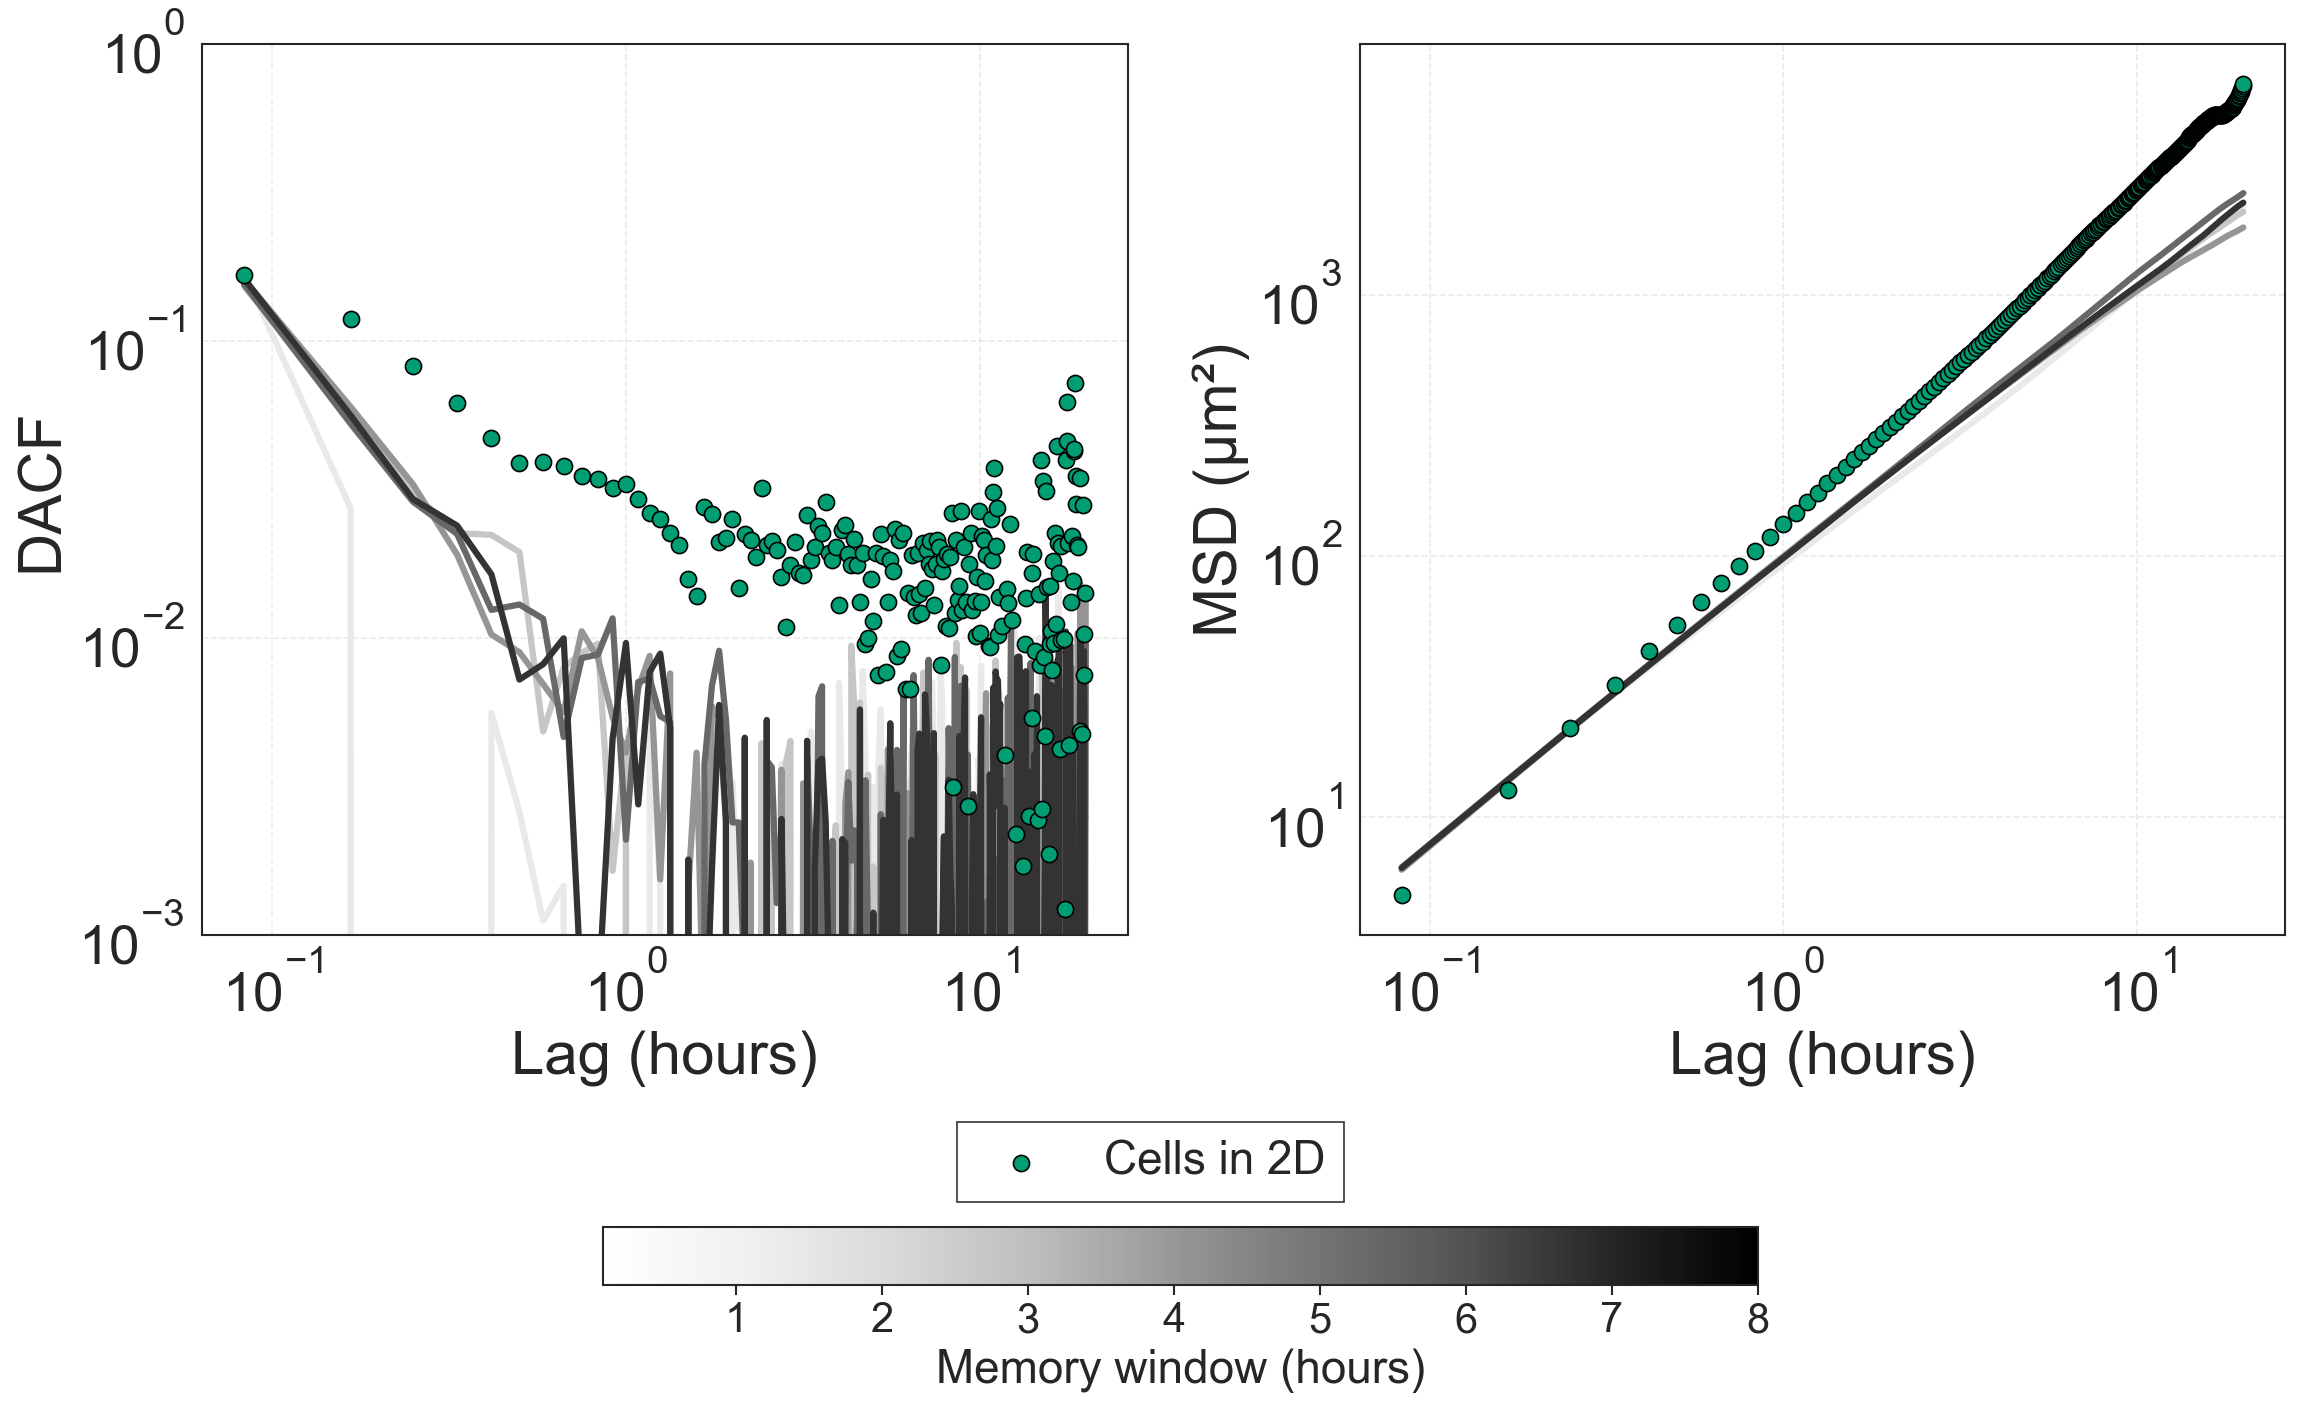

In [60]:

points_to_plot = 240  # number of points to show for clarity
palette = sns.color_palette("Greys", len(memory_windows))

fig, axes = plt.subplots(1, 2, figsize=(16, 10), dpi=150)

# conversion: 1 step = 5 minutes -> hours = steps * 5 / 60 = steps / 12
step_to_hours = 1.0 / 12.0

# =========================================================
# DACF plot (x axis in hours)
# =========================================================
# convert experimental dt to hours and filter zeros for log scale
dacf_lag_hours = np.asarray(dacf_exp['lag'][:points_to_plot].astype(float)) * step_to_hours
mask_nonzero = dacf_lag_hours > 0
if not mask_nonzero.all():
    num_dropped = (~mask_nonzero).sum()
    print(f"Warning: {num_dropped} DACF points with lag==0 were removed for log-x plotting.")

axes[0].scatter(dacf_lag_hours[mask_nonzero],
                dacf_exp['dacf_mean'][:points_to_plot].values[mask_nonzero],
                label='Cells in 2D',
                color=color_map["2D BTrack Tracking"],
                s=60, zorder=3, edgecolor='black')

for i, w in enumerate(memory_windows):
    d = results[w]['dacf']
    lag_hours_sim = np.asarray(d['lag'][:points_to_plot].astype(float)) * step_to_hours
    # mask zeros for plotting on log axis
    mask_sim = lag_hours_sim > 0
    if not mask_sim.all():
        # don't print every time; aggregate minimal info
        print(f"Note: memory window {w}: {np.sum(~mask_sim)} zero-lag points skipped for log-x.")
    axes[0].plot(lag_hours_sim[mask_sim], d['dacf'][:points_to_plot].values[mask_sim],
                 color=palette[i], linewidth=3, zorder=2)

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_ylim(1e-3, 1)
axes[0].set_xlabel('Lag (hours)')
axes[0].set_ylabel('DACF')
axes[0].grid(True, linestyle='--', alpha=0.4)

# =========================================================
# MSD plot (x axis in hours)
# =========================================================
msd_lag_hours = np.asarray(msd_exp['lag'][:points_to_plot].astype(float)) * step_to_hours
mask_nonzero_msd = msd_lag_hours > 0
if not mask_nonzero_msd.all():
    print(f"Warning: {np.sum(~mask_nonzero_msd)} MSD points with lag==0 were removed for log-x plotting.")

axes[1].scatter(msd_lag_hours[mask_nonzero_msd],
                msd_exp['msd_mean'][:points_to_plot].values[mask_nonzero_msd],
                label='FACSed DE on laminin',
                color=color_map["2D BTrack Tracking"],
                s=60, zorder=3, edgecolor='black')

for i, w in enumerate(memory_windows):
    m = results[w]['msd']
    lag_hours_sim = np.asarray(m['lag'][:points_to_plot].astype(float)) * step_to_hours
    mask_sim = lag_hours_sim > 0
    axes[1].plot(lag_hours_sim[mask_sim], m['msd'][:points_to_plot].values[mask_sim],
                 color=palette[i], linewidth=3, zorder=2)

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Lag (hours)')
axes[1].set_ylabel('MSD (μm²)')
axes[1].grid(True, linestyle='--', alpha=0.4)

# =========================================================
# Shared colorbar for memory window values (already normalized to hours)
# =========================================================
memory_windows_arr = np.array(memory_windows)
# normalizing to hours: divide by 12 (since memory_windows are in steps)
norm = mpl.colors.Normalize(vmin=(memory_windows_arr/12.0).min(), vmax=(memory_windows_arr/12.0).max())
sm = mpl.cm.ScalarMappable(cmap=mpl.cm.Greys, norm=norm)
sm.set_array([])

# --- Legend above colorbar ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.15),
    ncol=len(labels),
    fontsize=22,
    frameon=True,
    edgecolor='black',
    fancybox=False,
)

# --- Colorbar ---
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Memory window (hours)', fontsize=22)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout(rect=[0, 0.3, 1, 1])
plt.show()

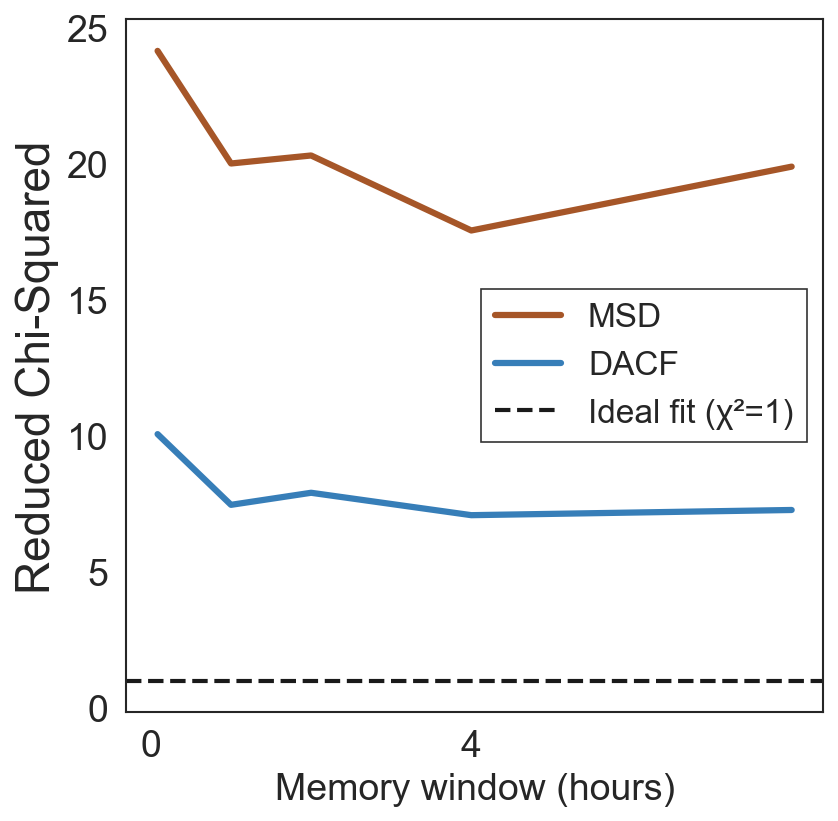

In [61]:
from fit import reduced_chi_squared
# Calculate reduced chi-squared for each memory window
chi2_results = []
steps_to_compare = 200
for w in memory_windows:
    d = results[w]['dacf']
    m = results[w]['msd']
    chi2_dacf = reduced_chi_squared(dacf_exp['dacf_mean'][:steps_to_compare], d['dacf'][:steps_to_compare], dacf_exp['dacf_sem'][:steps_to_compare])
    chi2_msd = reduced_chi_squared(msd_exp['msd_mean'][:steps_to_compare], m['msd'][:steps_to_compare], msd_exp['msd_sem'][:steps_to_compare])
    chi2_results.append({'memory_window': w, 'chi2_dacf': chi2_dacf, 'chi2_msd': chi2_msd})
chi2_df = pd.DataFrame(chi2_results)
# Plot chi-squared vs memory window
plt.figure(figsize=(6, 6), dpi=150)
plt.plot(chi2_df['memory_window'], chi2_df['chi2_msd'], marker='', label='MSD', linewidth=3, color='#a65628', markersize=8)
plt.plot(chi2_df['memory_window'], chi2_df['chi2_dacf'], marker='', label='DACF', linewidth=3, color='#377eb8', markersize=8)
plt.axhline(1, color='k', linestyle='--', label='Ideal fit (χ²=1)', linewidth=2)
plt.xlabel('Memory Window (hours)', fontsize=22)
plt.ylabel('Reduced Chi-Squared', fontsize=22)

# Each step = 5 minutes
step_minutes = 5
step_hours = step_minutes / 60

# Choose tick positions: every 5 hours
tick_interval_hours = 4
tick_interval_steps = tick_interval_hours / step_hours  # steps between ticks

# Select tick positions and labels
xticks = np.arange(0, chi2_df['memory_window'].max(), tick_interval_steps)
xtick_labels = (xticks * step_hours).round(1)  # convert to hours

plt.xticks(ticks=xticks, labels=[f"{x:g}" for x in (xticks * step_hours)], fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Memory window (hours)", fontsize=18)

# plt.title('Reduced Chi-Squared vs Memory Window')
plt.legend(frameon=True, edgecolor='black', fancybox=False, fontsize=16)
plt.show()

# Fit persistence

In [62]:
n_cells = 200
n_steps = 289
time_step = 5

# persistence values to test
persistence_list = np.linspace(0, 1, 20).tolist()  # None means infinite memory

results = {}
for p in persistence_list:
    sim_p = Simulation(
        n_cells=n_cells,
        time_step=time_step,
        stadium_L=8000,
        stadium_R=2000,
        source_length=400,
        chemotaxis_strength=0.0,
        repulsion_strength=0.0,
        interaction_radius=0.0,
        velocity_params={'shape': shape, 'loc': loc, 'scale': scale},
        persistence=p,
        starting_positions='uniform',
        mode='persistent',
        memory_window=None,
        memory_exp_lambda=None,
        memory_power_alpha=None,
        vonmises_params=vonmises_params['params']
    )
    sim_p.run(n_steps=n_steps)
    sim_df_p = sim_p.get_dataframe()
    msd_p = calculate_msd(sim_df_p, x_col='x', y_col='y')
    dacf_p = calculate_autocorrelation(sim_df_p)
    results[p] = {'sim': sim_p, 'df': sim_df_p, 'msd': msd_p, 'dacf': dacf_p}

Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps
Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps
Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps
Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 comple

In [63]:
exp_df = exp_df.groupby('track_id').filter(lambda x: len(x) >= 50)
msd_exp, dacf_exp = compute_msd_dacf_per_movie(exp_df, max_lag=None)

In [64]:
dacf_exp

lag  dacf_mean  dacf_std  dacf_sem      dt  n_total
0      0   1.000000  0.000000  0.000000     0.0  54526.0
1      1   0.166794  0.027798  0.009547     5.0  53962.0
2      2   0.118805  0.021479  0.007377    10.0  53429.0
3      3   0.082255  0.014154  0.004861    15.0  52918.0
4      4   0.062057  0.017365  0.005964    20.0  52407.0
..   ...        ...       ...       ...     ...      ...
284  284  -0.126693  0.331341  0.156196  1420.0     24.0
285  285   0.000614  0.517798  0.244092  1425.0     18.0
286  286  -0.244357  0.307617  0.145012  1430.0     12.0
287  287  -0.072228  0.619479  0.292025  1435.0      6.0
288  288        NaN       NaN       NaN  1440.0      5.0

[289 rows x 6 columns]

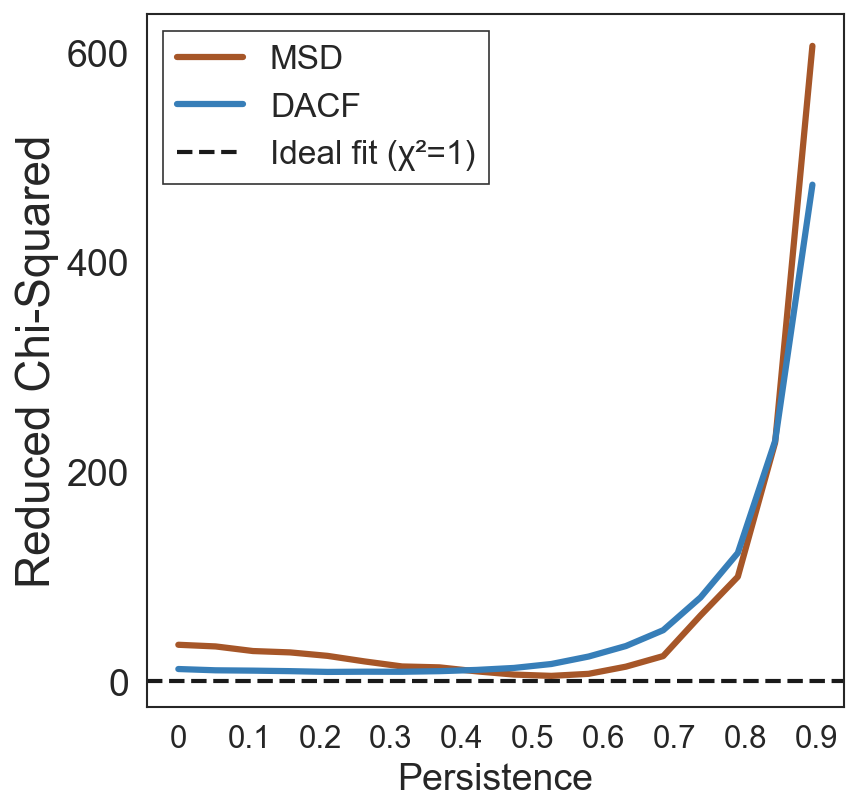

In [65]:
from fit import reduced_chi_squared
# Calculate reduced chi-squared for each memory window
chi2_results = []
steps_to_compare = 200
for p in persistence_list:
    d = results[p]['dacf']
    m = results[p]['msd']
    chi2_dacf = reduced_chi_squared(dacf_exp['dacf_mean'][:steps_to_compare], d['dacf'][:steps_to_compare], dacf_exp['dacf_sem'][:steps_to_compare])
    chi2_msd = reduced_chi_squared(msd_exp['msd_mean'][:steps_to_compare], m['msd'][:steps_to_compare], msd_exp['msd_sem'][:steps_to_compare])
    chi2_results.append({'persistence': p, 'chi2_dacf': chi2_dacf, 'chi2_msd': chi2_msd})
chi2_df = pd.DataFrame(chi2_results)
# Plot chi-squared vs memory window
plt.figure(figsize=(6, 6), dpi=150)
plt.plot(chi2_df['persistence'][:-2], chi2_df['chi2_msd'][:-2], marker='', label='MSD', linewidth=3, color='#a65628', markersize=8)
plt.plot(chi2_df['persistence'][:-2], chi2_df['chi2_dacf'][:-2], marker='', label='DACF', linewidth=3, color='#377eb8', markersize=8)
plt.axhline(1, color='k', linestyle='--', label='Ideal fit (χ²=1)', linewidth=2)
plt.xlabel('Persistence', fontsize=22)
plt.ylabel('Reduced Chi-Squared', fontsize=22)

# Select tick positions and labels
xticks = np.arange(0, chi2_df['persistence'].max(), 0.1)
xtick_labels = xticks  # persistence is already in desired units

plt.xticks(ticks=xticks, labels=[f"{x:g}" for x in xtick_labels], fontsize=15, rotation=0)
plt.yticks(fontsize=18)
plt.xlabel("Persistence", fontsize=18)

# plt.title('Reduced Chi-Squared vs Persistence')
plt.legend(frameon=True, edgecolor='black', fancybox=False, fontsize=16)
plt.show()

In [66]:
xtick_labels

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# Basics

In [67]:
# Demonstration: run three simulations (RW, PRW, BPRW) and plot DACF + MSD in one figure.
# Relies on Simulation, calculate_autocorrelation, calculate_msd, color_map, vonmises_params, shape, loc, scale already available.

# Simulation parameters
n_cells_demo = 200 if 'n_cells' not in globals() else n_cells
n_steps_demo = 240 if 'n_steps' not in globals() else n_steps
time_step_demo = 5 if 'time_step' not in globals() else time_step
velocity_params_demo = {'shape': shape, 'loc': loc, 'scale': scale}

modes = {
    'RW (random)': dict(mode='random', persistence=None, chemotaxis_strength=0.0, vonmises_params=None),
    'PRW (persistent)': dict(mode='persistent', persistence=0.7, chemotaxis_strength=0.0, vonmises_params=None),
    'BPRW (biased persistent)': dict(mode='biased_persistent', persistence=0.7, chemotaxis_strength=0.3, vonmises_params=None),
}

sims = {}
for name, opts in modes.items():
    sim_obj = Simulation(
        n_cells=n_cells_demo,
        time_step=time_step_demo,
        stadium_L=800,
        stadium_R=200,
        source_length=400,
        chemotaxis_strength=opts['chemotaxis_strength'],
        repulsion_strength=0.0,
        interaction_radius=0.0,
        velocity_params=velocity_params_demo,
        persistence=opts['persistence'],
        starting_positions='perimeter',
        mode=opts['mode'],
        memory_window=None,
        memory_exp_lambda=None,
        memory_power_alpha=None,
        vonmises_params=opts['vonmises_params']
    )
    print(f"Running {name} ...")
    sim_obj.run(n_steps=n_steps_demo)
    sim_df_local = sim_obj.get_dataframe()
    sims[name] = {
        'sim': sim_obj,
        'df': sim_df_local,
        'dacf': calculate_autocorrelation(sim_df_local),
        'msd': calculate_msd(sim_df_local, x_col='x', y_col='y')
    }

Running RW (random) ...
Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps
Running PRW (persistent) ...
Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps
Running BPRW (biased persistent) ...
Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps


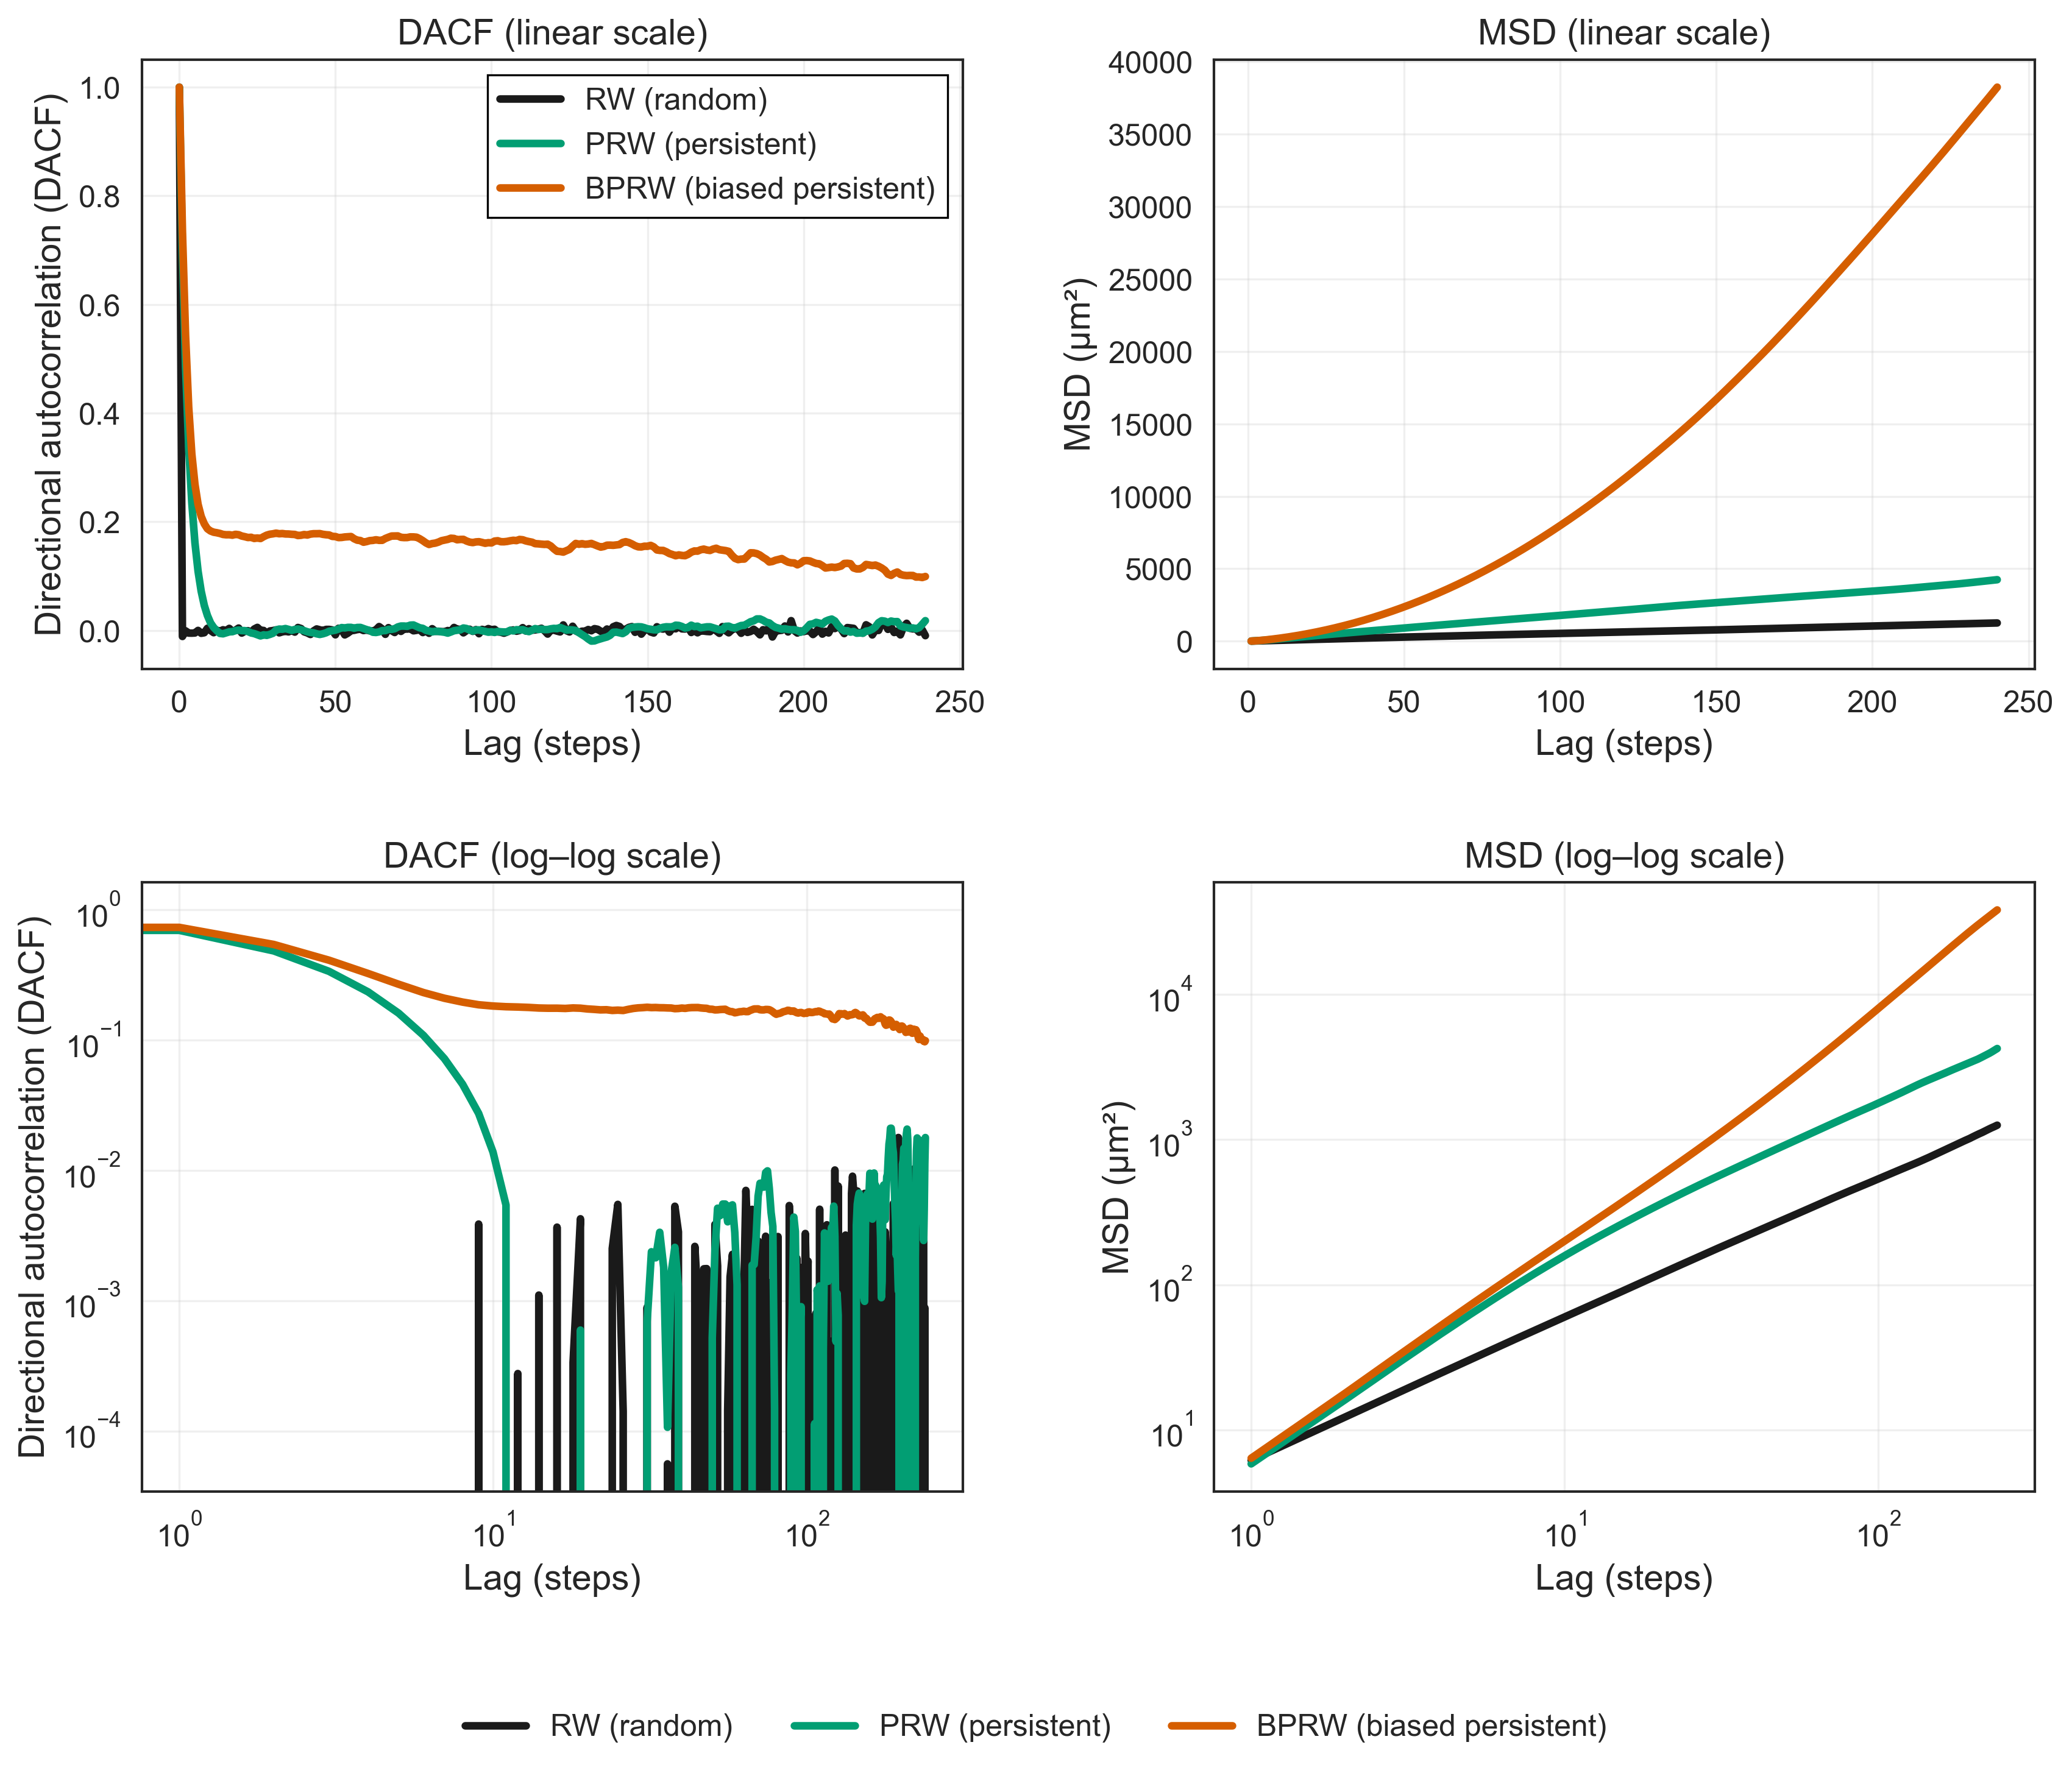

In [68]:
# Plot DACF and MSD in one figure (linear + log-log)
pts = 60 if 'points_to_plot' not in globals() else points_to_plot

# Create a 2x2 grid: [DACF-linear, MSD-linear; DACF-loglog, MSD-loglog]
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=300)

colors_demo = ["k", color_map["2D BTrack Tracking"], color_map["3D BTrack Tracking"]]

# -----------------------------
# Row 1: Linear scale
# -----------------------------

# DACF (linear)
for (name, entry), c in zip(sims.items(), colors_demo):
    d = entry['dacf']
    axes[0, 0].plot(d['lag'][:pts], d['dacf'][:pts], marker='', linestyle='-', label=name, color=c, linewidth=3)
axes[0, 0].set_xlabel('Lag (steps)', fontsize=14)
axes[0, 0].set_ylabel('Directional autocorrelation (DACF)', fontsize=14)
axes[0, 0].legend(loc='upper right', frameon=True, fontsize=12, edgecolor='black', fancybox=False, framealpha=1)
axes[0, 0].tick_params(axis='both', which='major', labelsize=12)
axes[0, 0].set_title("DACF (linear scale)", fontsize=14)
axes[0, 0].grid(which='major', alpha=0.3)

# MSD (linear)
for (name, entry), c in zip(sims.items(), colors_demo):
    m = entry['msd']
    axes[0, 1].plot(m['lag'][:pts], m['msd'][:pts], marker='', linestyle='-', label=name, color=c, linewidth=3)
axes[0, 1].set_xlabel('Lag (steps)', fontsize=14)
axes[0, 1].set_ylabel('MSD (μm²)', fontsize=14)
axes[0, 1].tick_params(axis='both', which='major', labelsize=12)
axes[0, 1].set_title("MSD (linear scale)", fontsize=14)
axes[0, 1].grid(which='major', alpha=0.3)

# -----------------------------
# Row 2: Log–log scale
# -----------------------------

# DACF (log-log)
for (name, entry), c in zip(sims.items(), colors_demo):
    d = entry['dacf']
    axes[1, 0].plot(d['lag'][:pts], d['dacf'][:pts], marker='', linestyle='-', label=name, color=c, linewidth=3)
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('Lag (steps)', fontsize=14)
axes[1, 0].set_ylabel('Directional autocorrelation (DACF)', fontsize=14)
axes[1, 0].tick_params(axis='both', which='major', labelsize=12)
axes[1, 0].set_title("DACF (log–log scale)", fontsize=14)
axes[1, 0].grid(which='major', alpha=0.3)

# MSD (log-log)
for (name, entry), c in zip(sims.items(), colors_demo):
    m = entry['msd']
    axes[1, 1].plot(m['lag'][:pts], m['msd'][:pts], marker='', linestyle='-', label=name, color=c, linewidth=3)
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlabel('Lag (steps)', fontsize=14)
axes[1, 1].set_ylabel('MSD (μm²)', fontsize=14)
axes[1, 1].tick_params(axis='both', which='major', labelsize=12)
axes[1, 1].set_title("MSD (log–log scale)", fontsize=14)
axes[1, 1].grid(which='major', alpha=0.3)

# -----------------------------
# Layout and legend
# -----------------------------
# Shared legend (optional, cleaner)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(colors_demo), fontsize=12, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave room for shared legend
plt.show()


In [69]:
sims.items()

dict_items([('RW (random)', {'sim': <simulation.Simulation object at 0x0000019036A1CC10>, 'df':        track_id  step     t           x           y       v_x       v_y
0             0     0     0  200.000000 -400.000000  0.000000  0.000000
1             0     1     5  198.797975 -399.797185 -1.202025  0.202815
2             0     2    10  198.980440 -400.414701  0.182465 -0.617517
3             0     3    15  199.394892 -400.203488  0.414452  0.211213
4             0     4    20  198.615981 -401.012118 -0.778911 -0.808630
...         ...   ...   ...         ...         ...       ...       ...
57995       199   285  1425  192.298097 -381.972524 -0.703721  1.930171
57996       199   286  1430  192.578780 -381.511086  0.280683  0.461438
57997       199   287  1435  194.305946 -382.738141  1.727166 -1.227055
57998       199   288  1440  191.438483 -383.016466 -2.867463 -0.278325
57999       199   289  1445  190.598259 -383.112671 -0.840224 -0.096204

[58000 rows x 7 columns], 'dacf':      

C:\Users\davidzi\AppData\Local\Temp\ipykernel_95900\141708142.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.07, 1, 1])  # leave space for shared legend


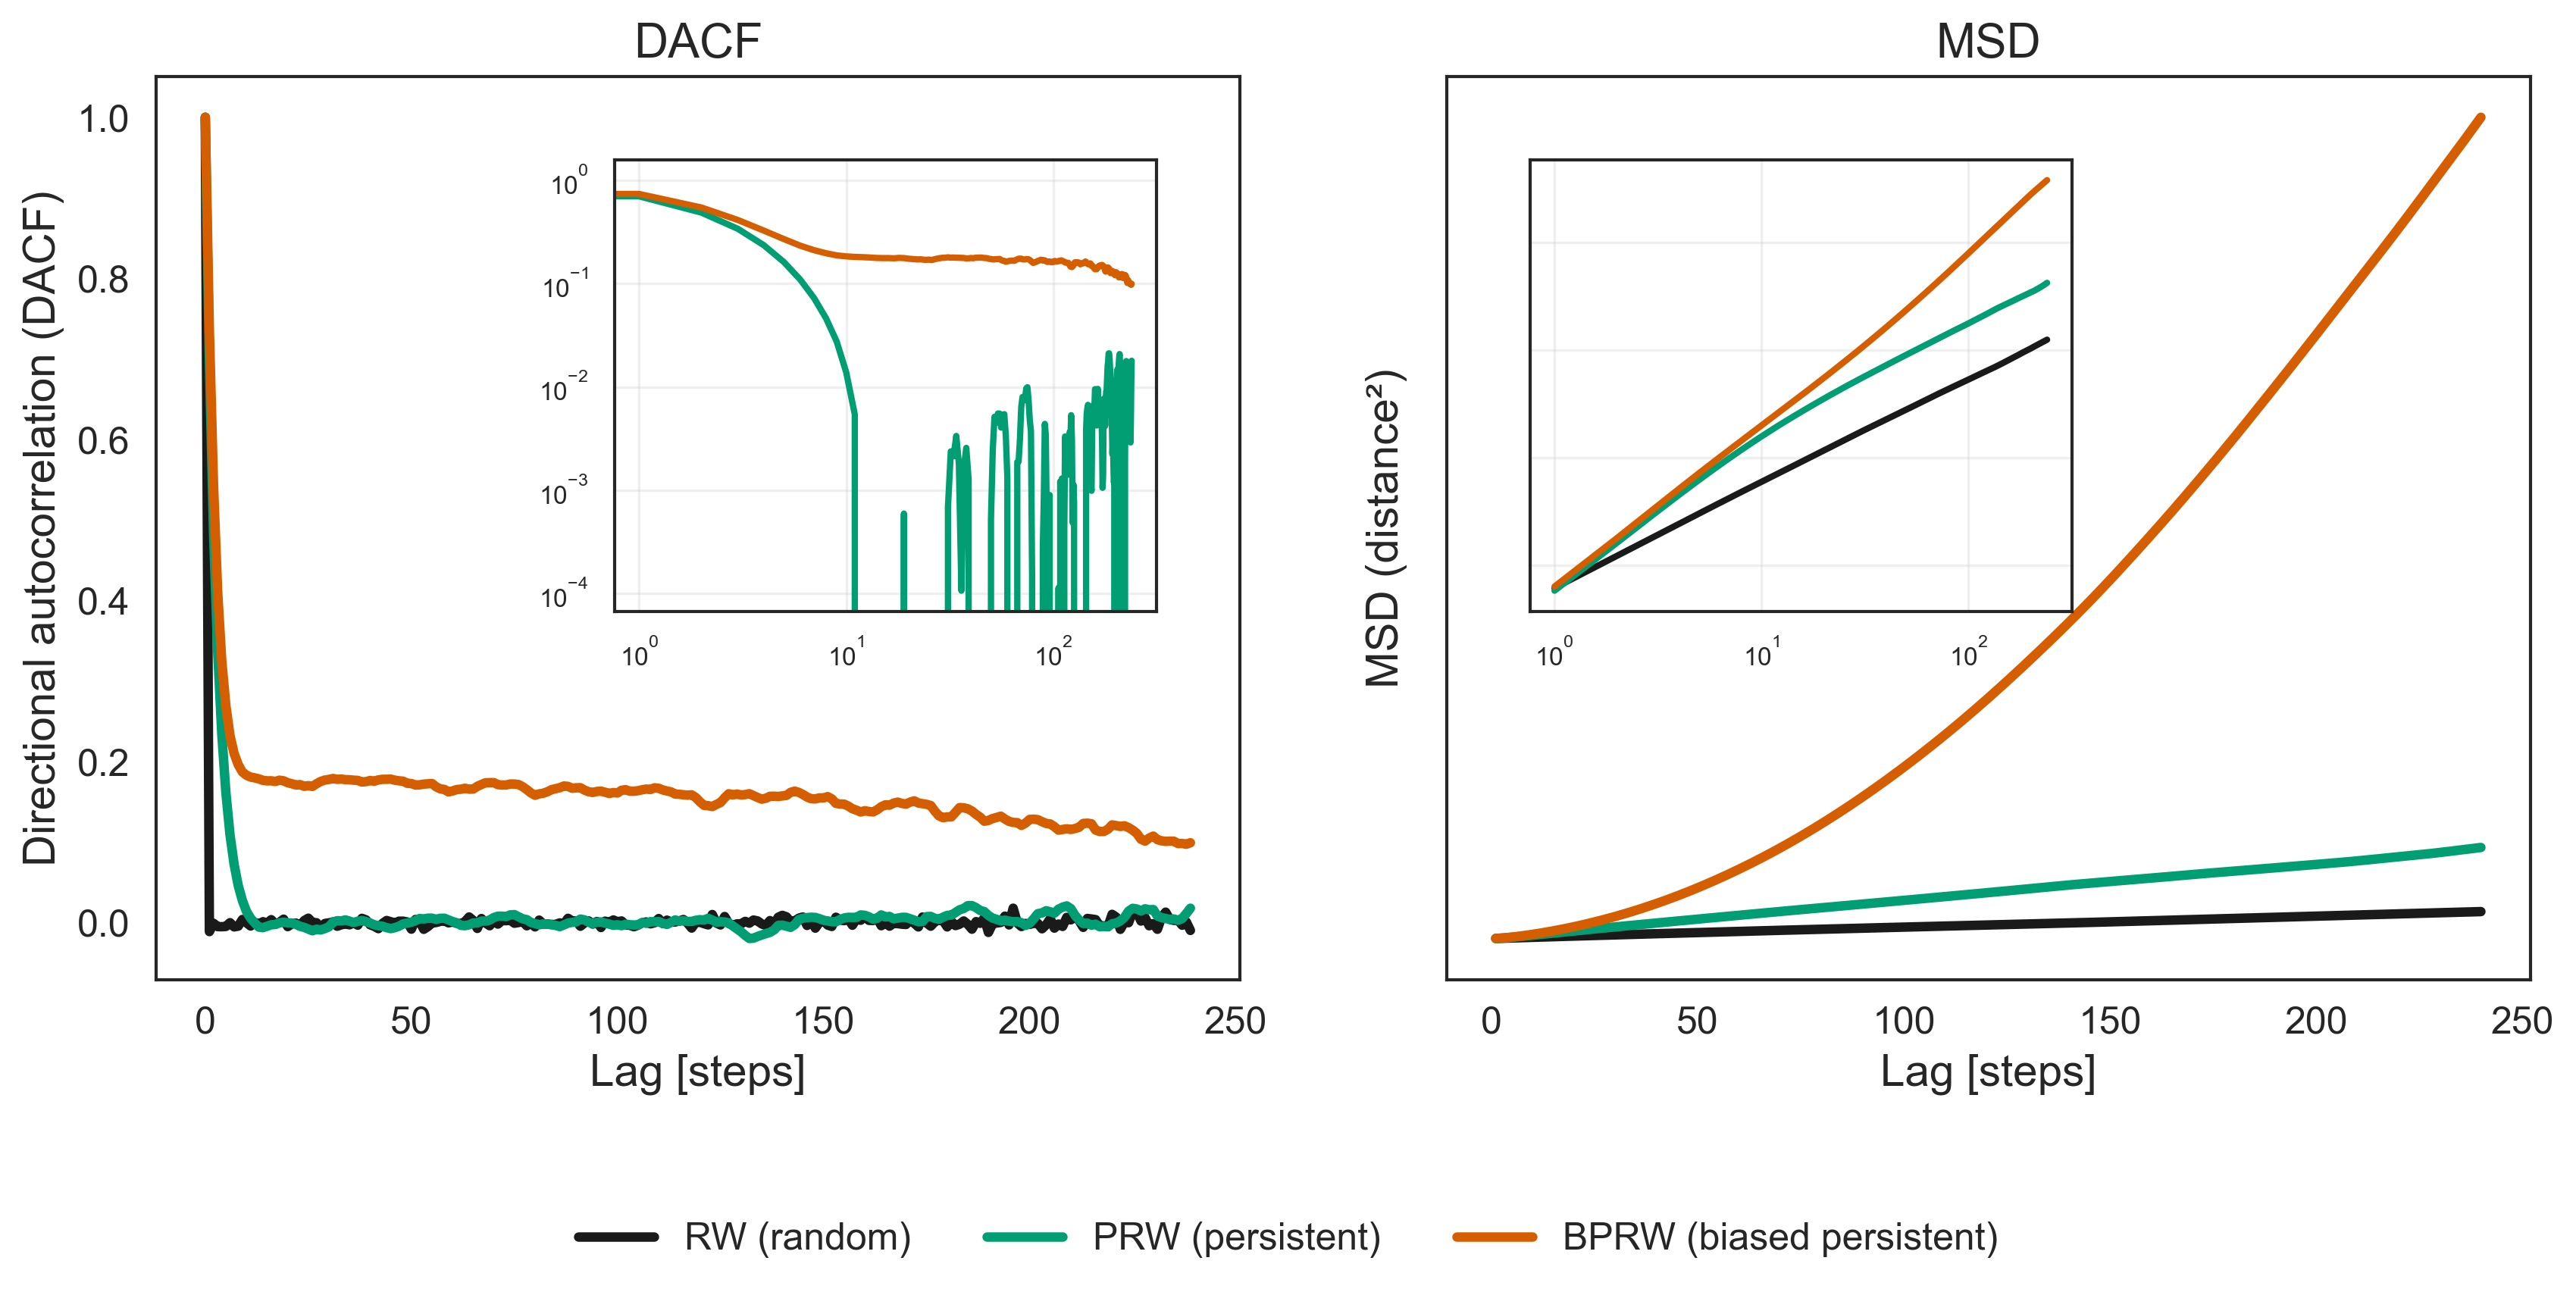

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

pts = 60 if 'points_to_plot' not in globals() else points_to_plot

# Main figure with two panels
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

colors_demo = ["k", color_map["2D BTrack Tracking"], color_map["3D BTrack Tracking"]]

# =========================================================
# DACF main plot (linear) + inset (log–log, upper right)
# =========================================================
ax_main = axes[0]
ax_inset = inset_axes(ax_main, width="50%", height="50%", loc="upper right", borderpad=1)

for (name, entry), c in zip(sims.items(), colors_demo):
    d = entry['dacf']
    # Main (linear)
    ax_main.plot(d['lag'][:pts], d['dacf'][:pts], color=c, linewidth=3, label=name)
    # Inset (log–log) (without RW, which isn't visible there)
    if name != "RW (random)":
        ax_inset.plot(d['lag'][:pts], d['dacf'][:pts], color=c, linewidth=2)

# Main DACF setup
ax_main.set_xlabel('Lag [steps]', fontsize=14)
ax_main.set_ylabel('Directional autocorrelation (DACF)', fontsize=14)
ax_main.tick_params(axis='both', which='major', labelsize=12)
ax_main.set_title("DACF", fontsize=15)
# ax_main.grid(alpha=0.3)

# Inset DACF setup
ax_inset.set_xscale('log')
ax_inset.set_yscale('log')
ax_inset.tick_params(axis='both', which='major', labelsize=8)
ax_inset.grid(alpha=0.3)

# =========================================================
# MSD main plot (linear) + inset (log–log, upper left)
# =========================================================
ax_main = axes[1]
ax_inset = inset_axes(ax_main, width="50%", height="50%", loc="upper left", borderpad=1)

for (name, entry), c in zip(sims.items(), colors_demo):
    m = entry['msd']
    # Main (linear)
    ax_main.plot(m['lag'][:pts], m['msd'][:pts], color=c, linewidth=3, label=name)
    # Inset (log–log)
    ax_inset.plot(m['lag'][:pts], m['msd'][:pts], color=c, linewidth=2)

# Main MSD setup
ax_main.set_xlabel('Lag [steps]', fontsize=14)
ax_main.set_ylabel('MSD (distance²)', fontsize=14)
# remove ticks for clarity
# ax_main.xaxis.set_major_formatter(plt.NullFormatter())
ax_main.yaxis.set_major_formatter(plt.NullFormatter())
ax_main.tick_params(axis='both', which='major', labelsize=12)
ax_main.set_title("MSD", fontsize=15)
# ax_main.grid(alpha=0.3)

# Inset MSD setup
ax_inset.set_xscale('log')
ax_inset.set_yscale('log')
# remove ticks for clarity
# ax_inset.xaxis.set_major_formatter(plt.NullFormatter())
ax_inset.yaxis.set_major_formatter(plt.NullFormatter())
ax_inset.tick_params(axis='both', which='major', labelsize=8)
ax_inset.grid(alpha=0.3)

# =========================================================
# Shared legend below both plots
# =========================================================
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(colors_demo),
           fontsize=12, frameon=False)

plt.tight_layout(rect=[0, 0.07, 1, 1])  # leave space for shared legend
plt.show()

In [72]:
# Compare inward bias: run PRW sims (10 repeats per persistence), compute mean inward velocity (vx,vy · unit(center - pos))
# and compare to experimental data (patterned_cells_data from 2024-09-09 -> exp_df).
#
# Relies on: Simulation, exp_df, shape/loc/scale (velocity params), seaborn, matplotlib, numpy, pandas already imported.

persistence_values = [0.0, 0.3, 0.6, 0.9]
n_repeats = 10
n_cells_sim = 200 if 'n_cells' not in globals() else n_cells
n_steps_sim = 240 if 'n_steps' not in globals() else n_steps
time_step_sim = 5  # minutes (kept consistent with previous simulations)

exp_df_in = exp_df.copy()
# Ensure exp_df has v_x, v_y; keep fallback (may be used elsewhere)
if not {'v_x', 'v_y'}.issubset(exp_df.columns):
    exp_df_in = exp_df.copy()
    exp_df_in['dx'] = exp_df_in.groupby('track_id')['x'].diff()
    exp_df_in['dy'] = exp_df_in.groupby('track_id')['y'].diff()
    exp_df_in['v_x'] = exp_df_in['dx'] / time_step_sim
    exp_df_in['v_y'] = exp_df_in['dy'] / time_step_sim

In [73]:
exp_df_in

file   ID                     track_id     t  \
2      2024_09_09_tracks_01.h5    1    2024_09_09_tracks_01.h5_1     0   
3      2024_09_09_tracks_01.h5    1    2024_09_09_tracks_01.h5_1     5   
4      2024_09_09_tracks_01.h5    1    2024_09_09_tracks_01.h5_1    10   
5      2024_09_09_tracks_01.h5    1    2024_09_09_tracks_01.h5_1    15   
6      2024_09_09_tracks_01.h5    1    2024_09_09_tracks_01.h5_1    20   
...                        ...  ...                          ...   ...   
88941  2024_09_09_tracks_11.h5  575  2024_09_09_tracks_11.h5_575  1420   
88942  2024_09_09_tracks_11.h5  575  2024_09_09_tracks_11.h5_575  1425   
88943  2024_09_09_tracks_11.h5  575  2024_09_09_tracks_11.h5_575  1430   
88944  2024_09_09_tracks_11.h5  575  2024_09_09_tracks_11.h5_575  1435   
88945  2024_09_09_tracks_11.h5  575  2024_09_09_tracks_11.h5_575  1440   

       normalized_time     x_pixels    y_pixels   x_microns   y_microns  \
2                    0  1118.325317  799.446411  357.864102  255.822852   
3                    5  1118.082520  803.064575  357.786406  256.980664   
4                   10  1120.718384  806.075073  358.629883  257.944023   
5                   15  1128.284546  808.816040  361.051055  258.821133   
6                   20  1131.813599  810.956177  362.180352  259.505977   
...                ...          ...         ...         ...         ...   
88941              225   508.903015  438.321014  162.848965  140.262725   
88942              230   506.737091  436.879944  162.155869  139.801582   
88943              235   511.317352  437.989105  163.621553  140.156514   
88944              240   514.204285  442.368988  164.545371  141.558076   
88945              245   519.161499  450.168793  166.131680  144.054014   

       major_axis_length_microns  ...  distance_from_edge_pixels  \
2                      17.507222  ...                 456.684793   
3                      16.842682  ...                 456.483297   
4                      17.549938  ...                 458.353575   
5                      17.075037  ...                 466.274597   
6                      13.198544  ...                 469.208909   
...                          ...  ...                        ...   
88941                  14.652271  ...                   0.000000   
88942                  15.296740  ...                   0.000000   
88943                  15.411550  ...                   0.000000   
88944                  14.108744  ...                   0.000000   
88945                  13.945405  ...                   0.000000   

       distance_from_edge_microns  step        dx        dy  velocity  \
2                      146.139134     0       NaN       NaN       NaN   
3                      146.074655     1 -0.077695  1.157813  0.232083   
4                      146.673144     2  0.843477  0.963359  0.256087   
5                      149.207871     3  2.421172  0.877109  0.515030   
6                      150.146851     4  1.129297  0.684844  0.264146   
...                           ...   ...       ...       ...       ...   
88941                    0.000000    45  2.558887 -0.384141  0.517512   
88942                    0.000000    46 -0.693096 -0.461143  0.166497   
88943                    0.000000    47  1.465684  0.354932  0.301609   
88944                    0.000000    48  0.923818  1.401563  0.335727   
88945                    0.000000    49  1.586309  2.495937  0.591475   

            v_x       v_y           x           y  
2           NaN       NaN  357.864102  255.822852  
3     -0.015539  0.231563  357.786406  256.980664  
4      0.168695  0.192672  358.629883  257.944023  
5      0.484234  0.175422  361.051055  258.821133  
6      0.225859  0.136969  362.180352  259.505977  
...         ...       ...         ...         ...  
88941  0.511777 -0.076828  162.848965  140.262725  
88942 -0.138619 -0.092229  162.155869  139.801582  
88943  0.293137  0.070986  163.621553  140.156514  
88944  0.184764  0.280

In [74]:
# Compute inward velocity as change in distance from pattern edge per time:
# clean all points where distance_from_edge_microns is non-possitive (cannot compute meaningful inward velocity)
exp_df_in = exp_df_in[exp_df_in['distance_from_edge_microns'] > 0]
exp_df_in['v_inward_microns_per_min'] = - exp_df_in.groupby('track_id')['distance_from_edge_microns'].diff() / time_step_sim

# keep inward velocities only when normal velocity is defined and non-zero
exp_df_in = exp_df_in[exp_df_in['v_x'].notna() & exp_df_in['v_y'].notna()]
exp_df_in = exp_df_in[(exp_df_in['v_x'] != 0) | (exp_df_in['v_y'] != 0)]

# remove zero inward velocities (no movement)
exp_df_in = exp_df_in[exp_df_in['v_inward_microns_per_min'].notna() & (exp_df_in['v_inward_microns_per_min'] != 0)]

exp_df_in['v_inward_microns_per_hour'] = exp_df_in['v_inward_microns_per_min'] * 60

C:\Users\davidzi\AppData\Local\Temp\ipykernel_95900\2014982529.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_in['v_inward_microns_per_min'] = - exp_df_in.groupby('track_id')['distance_from_edge_microns'].diff() / time_step_sim


In [75]:
# Normalize inward velocities for comparison: v_inward_norm = v_inward / sigma_v_inward
# Uses existing variables: exp_df_in (with 'v_inward_microns_per_min') and sim_results_df (with 'mean_inward').

# Experimental: compute overall sigma (std) and per-track means
sigma_exp = exp_df_in['v_inward_microns_per_min'].std(ddof=1)
if sigma_exp == 0 or np.isnan(sigma_exp):
    raise ValueError("Experimental sigma is zero or NaN; cannot normalize.")

# per-sample normalization
exp_df_in['v_inward_norm'] = exp_df_in['v_inward_microns_per_min'] / sigma_exp

# per-track mean and normalized per-track mean
exp_track_means = exp_df_in.groupby('track_id')['v_inward_microns_per_min'] \
                           .mean().reset_index(name='v_inward_track_mean')
exp_track_means['v_inward_track_mean_norm'] = exp_track_means['v_inward_track_mean'] / sigma_exp

# # Simulation: normalize mean_inward (per-run) using experimental sigma for direct comparison
# sim_results_df['mean_inward_norm'] = sim_results_df['mean_inward'] / sigma_exp

# # Also compute per-persistence summaries (mean, std) and their normalized mean
# sim_summary = sim_results_df.groupby('persistence')['mean_inward'] \
#                             .agg(['mean', 'std', 'count']).reset_index()
# sim_summary['mean_norm'] = sim_summary['mean'] / sigma_exp

# Print brief summary
print(f"Experimental sigma (v_inward, μm/min): {sigma_exp:.5f}")
print("Experimental per-track mean (first 5):")
print(exp_track_means.head())
print("\nSimulation summary by persistence:")
# print(sim_summary)

# Keep variables for downstream cells: exp_df_in, exp_track_means, sim_results_df, sim_summary, sigma_exp

Experimental sigma (v_inward, μm/min): 0.31308
Experimental per-track mean (first 5):
                      track_id  v_inward_track_mean  v_inward_track_mean_norm
0    2024_09_09_tracks_01.h5_1             0.061906                  0.197733
1   2024_09_09_tracks_01.h5_10            -0.010507                 -0.033562
2  2024_09_09_tracks_01.h5_134            -0.020923                 -0.066830
3   2024_09_09_tracks_01.h5_14            -0.085895                 -0.274354
4  2024_09_09_tracks_01.h5_153            -0.014869                 -0.047492

Simulation summary by persistence:


In [76]:
# Run simulations and compute mean inward velocity per simulation
sim_records = []
for p in persistence_values:
    for run_idx in range(n_repeats):
        sim_obj = Simulation(
            n_cells=n_cells_sim,
            time_step=time_step_sim,
            stadium_L=800, stadium_R=200, source_length=400,
            chemotaxis_strength=0.0,
            repulsion_strength=0.0, interaction_radius=0.0,
            velocity_params={'shape': shape, 'loc': loc, 'scale': scale},
            persistence=p,
            starting_positions='perimeter',
            mode='persistent',
            memory_window=None,
            vonmises_params=None
        )
        sim_obj.run(n_steps=n_steps_sim)
        sim_df = sim_obj.get_dataframe()

        # find id column
        id_col = next((c for c in sim_df.columns if c in ('cell', 'cell_id', 'track_id', 'id')), None)
        if id_col is None:
            # assume each unique combination of (x,y) sequence belongs to a synthetic id column
            sim_df = sim_df.copy()
            sim_df['cell'] = sim_df.groupby((sim_df['x'].shift() != sim_df['x']).cumsum()).ngroup()
            id_col = 'cell'

        # compute velocities from positions
        sim_df = sim_df.sort_values([id_col, 'step'] if 'step' in sim_df.columns else [id_col])
        sim_df['dx'] = sim_df.groupby(id_col)['x'].diff()
        sim_df['dy'] = sim_df.groupby(id_col)['y'].diff()
        sim_df['v_x'] = sim_df['dx'] / time_step_sim
        sim_df['v_y'] = sim_df['dy'] / time_step_sim

        # align sim center to experimental center (translate simulation coords so their centroid matches exp_center)
        sim_center = sim_df[['x', 'y']].mean().values
        sim_positions = sim_df[['x', 'y']].values + (exp_center - sim_center)

        vec_to_center_sim = exp_center - sim_positions
        dist_sim = np.linalg.norm(vec_to_center_sim, axis=1)
        mask_sim_nz = dist_sim > 0
        ux_sim = np.zeros_like(vec_to_center_sim)
        ux_sim[mask_sim_nz] = (vec_to_center_sim[mask_sim_nz].T / dist_sim[mask_sim_nz]).T

        v_inward_sim = (sim_df[['v_x', 'v_y']].fillna(0).values * ux_sim).sum(axis=1)
        # drop nan/first-step zeros
        v_inward_sim = v_inward_sim[~np.isnan(v_inward_sim)]
        # compute mean inward velocity for this simulation
        mean_inward = np.mean(v_inward_sim) if len(v_inward_sim) > 0 else np.nan

        sim_records.append({'persistence': p, 'run': run_idx, 'mean_inward': mean_inward})

sim_results_df = pd.DataFrame(sim_records)

Step 25/289 completed
Step 50/289 completed
Step 75/289 completed
Step 100/289 completed
Step 125/289 completed
Step 150/289 completed
Step 175/289 completed
Step 200/289 completed
Step 225/289 completed
Step 250/289 completed
Step 275/289 completed
Simulation completed: 289 steps


NameError: name 'exp_center' is not defined

C:\Users\davidzi\AppData\Local\Temp\ipykernel_12500\4007893839.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sim_results_df, x='persistence', y='mean_inward', palette='Blues', showfliers=False)


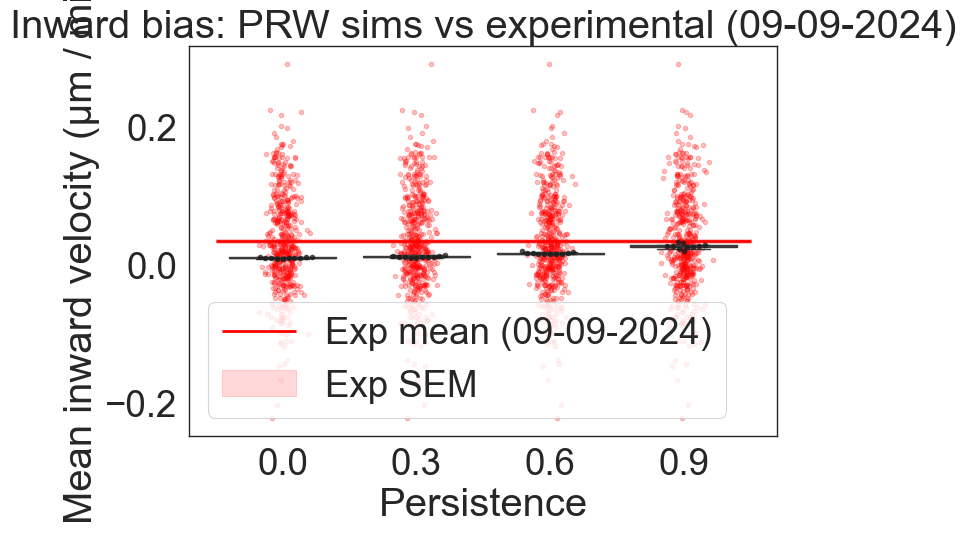

Simulation summary by persistence:
    persistence      mean       std  count
0          0.0  0.010262  0.000921     10
1          0.3  0.011785  0.001485     10
2          0.6  0.016784  0.001786     10
3          0.9  0.027288  0.003744     10

Experimental overall mean inward velocity: 0.0347 ± 0.0031 (SEM)


In [ ]:
# Plot comparison: boxplot of sims by persistence, overlay experimental per-track means and overall mean ± SEM
plt.figure(figsize=(8, 6))
sns.boxplot(data=sim_results_df, x='persistence', y='mean_inward', palette='Blues', showfliers=False)
sns.swarmplot(data=sim_results_df, x='persistence', y='mean_inward', color='k', size=4, alpha=0.8)

# overlay experimental per-track points (jittered) and mean ± SEM
x_positions = list(range(len(persistence_values)))
# plot per-track experimental points at each persistence x (so they line up visually)
for xi in x_positions:
    plt.scatter(np.random.normal(xi, 0.06, size=len(exp_track_means)),
                exp_track_means['v_inward_track_mean'],
                color='red', alpha=0.25, s=10)

# overall experimental mean line and shaded sem
plt.hlines(exp_overall_mean, xmin=-0.5, xmax=len(persistence_values)-0.5, colors='red', linewidth=2, label='Exp mean (09-09-2024)')
plt.fill_between([-0.5, len(persistence_values)-0.5],
                 [exp_overall_mean - exp_overall_sem]*2,
                 [exp_overall_mean + exp_overall_sem]*2,
                 color='red', alpha=0.15, label='Exp SEM')

plt.xlabel('Persistence')
plt.ylabel('Mean inward velocity (μm / min)')
plt.title('Inward bias: PRW sims vs experimental (09-09-2024)')
plt.legend()
plt.tight_layout()
plt.show()

# Return sim_results_df and experimental summary for downstream inspection
sim_results_df_summary = sim_results_df.groupby('persistence')['mean_inward'].agg(['mean','std','count']).reset_index()
print("Simulation summary by persistence:\n", sim_results_df_summary)
print(f"\nExperimental overall mean inward velocity: {exp_overall_mean:.4f} ± {exp_overall_sem:.4f} (SEM)")

# Check for Bias Towards Pattern Center

Comparing inward velocity distributions between experimental data and PRW simulations to detect potential bias toward pattern centers.

In [90]:
# Step 1: Calculate inward velocity from experimental data
# Inward velocity = last_distance - first_distance / time_step
# IMPORTANT: We use distance from EDGE, not from center, because the pattern is stadium-shaped

patterned_cells_data = pd.read_csv(r'D:\David\THESIS\tracks_dataframes\tracks_df_2024_09_09_FoxA2_tdTom_c211to300_BmpAct_day2To3.csv')

exp_data = patterned_cells_data.copy()

# Filter for minimum track length
minimum_track_length = 30
exp_data = exp_data.groupby('track_id').filter(lambda x: len(x) >= minimum_track_length)

# Filter out tracks with any non-positive distances (cannot compute meaningful inward velocity)
# Use groupby/filter for efficiency instead of looping and reassigning inside loop
exp_data = exp_data.groupby('track_id').filter(lambda x: (x['distance_from_edge_microns'] > 0).all())

print(f"Number of tracks after filtering: {exp_data['track_id'].nunique()}")
# Calculate time step (assuming 5 minutes)
time_step_bias = 5  # minutes

Number of tracks after filtering: 632


In [91]:
required_cols = {'x_microns', 'y_microns', 'mask_center_x_microns', 'mask_center_y_microns'}
missing = required_cols - set(exp_data.columns)
if missing:
    raise KeyError(f"Missing required columns to compute distance_from_center_microns: {missing}")

exp_data['distance_from_center_microns'] = np.sqrt(
    (exp_data['x_microns'] - exp_data['mask_center_x_microns'])**2 +
    (exp_data['y_microns'] - exp_data['mask_center_y_microns'])**2
)

# show a quick summary
print(exp_data[['x_microns','y_microns','mask_center_x_microns','mask_center_y_microns','distance_from_center_microns']].head())

    x_microns   y_microns  mask_center_x_microns  mask_center_y_microns  \
2  357.864102  255.822852                 320.64                 597.76   
3  357.786406  256.980664                 320.64                 597.76   
4  358.629883  257.944023                 320.64                 597.76   
5  361.051055  258.821133                 320.64                 597.76   
6  362.180352  259.505977                 320.64                 597.76   

   distance_from_center_microns  
2                    343.957333  
3                    342.797916  
4                    341.932931  
5                    341.339434  
6                    340.795225  


In [92]:
# Step 2: Calculate per-trajectory inward velocity for experimental data
# Inward velocity = (final_distance - initial_distance) / total_time

# Calculate per-trajectory metrics
distance_col = 'distance_from_center_microns'
exp_trajectory_data = []

for track_id in exp_data['track_id'].unique():
    track = exp_data[exp_data['track_id'] == track_id].sort_index()
    
    if len(track) < 2:
        continue
    
    # Get first and last distance from edge
    dist_initial = track[distance_col].iloc[0]
    dist_final = track[distance_col].iloc[-1]
    
    # Calculate change in distance
    diff_distance = dist_final - dist_initial
    
    # Calculate trajectory duration
    n_steps_track = len(track) - 1
    duration = n_steps_track * time_step_bias  # in minutes
    
    # Inward velocity: -diff_distance / duration
    # Positive means moving inward (toward center, distance from center decreases)
    v_inward = - diff_distance / duration if duration > 0 else np.nan
    
    # Skip if invalid
    if np.isnan(v_inward) or v_inward == 0:
        continue
    
    exp_trajectory_data.append({
        'track_id': track_id,
        'v_inward': v_inward,
        'v_inward_per_hour': v_inward * 60,  # convert to μm/hour
        'initial_distance': dist_initial,
        'final_distance': dist_final,
        'duration': duration,
        'n_points': len(track)
    })

exp_trajectories_df = pd.DataFrame(exp_trajectory_data)

# Calculate normalization factor (std of per-trajectory velocities)
sigma_v_inward = exp_trajectories_df['v_inward'].std()

# Normalize
exp_trajectories_df['v_inward_normalized'] = exp_trajectories_df['v_inward'] / sigma_v_inward

print(f"\nPer-trajectory analysis (EXPERIMENTAL):")
print(f"  Total trajectories: {len(exp_trajectories_df)}")
print(f"  Mean trajectory duration: {exp_trajectories_df['duration'].mean():.1f} minutes")
print(f"  Mean inward velocity: {exp_trajectories_df['v_inward'].mean():.4f} μm/min")
print(f"    (Positive = toward center, Negative = away from center)")
print(f"  Std inward velocity (σ): {sigma_v_inward:.4f} μm/min")
print(f"\nNormalized statistics:")
print(f"  Mean (normalized): {exp_trajectories_df['v_inward_normalized'].mean():.4f}")
print(f"  Std (normalized): {exp_trajectories_df['v_inward_normalized'].std():.4f}")
print(f"  Median (normalized): {exp_trajectories_df['v_inward_normalized'].median():.4f}")

# Store for later comparison
exp_v_inward_normalized = exp_trajectories_df['v_inward_normalized'].values


Per-trajectory analysis (EXPERIMENTAL):
  Total trajectories: 632
  Mean trajectory duration: 402.8 minutes
  Mean inward velocity: 0.0440 μm/min
    (Positive = toward center, Negative = away from center)
  Std inward velocity (σ): 0.0750 μm/min

Normalized statistics:
  Mean (normalized): 0.5864
  Std (normalized): 1.0000
  Median (normalized): 0.4944


In [93]:
exp_trajectories_df

track_id  v_inward  v_inward_per_hour  \
0      2024_09_09_tracks_01.h5_1  0.102550           6.152980   
1     2024_09_09_tracks_01.h5_16  0.009650           0.579000   
2     2024_09_09_tracks_01.h5_14  0.034158           2.049478   
3      2024_09_09_tracks_01.h5_6  0.157898           9.473901   
4      2024_09_09_tracks_01.h5_4  0.057811           3.468656   
..                           ...       ...                ...   
627  2024_09_09_tracks_11.h5_566  0.053426           3.205554   
628  2024_09_09_tracks_11.h5_570  0.102944           6.176636   
629  2024_09_09_tracks_11.h5_584  0.033624           2.017421   
630  2024_09_09_tracks_11.h5_587  0.060957           3.657442   
631  2024_09_09_tracks_11.h5_606  0.068726           4.123566   

     initial_distance  final_distance  duration  n_points  v_inward_normalized  
0          343.957333      248.586149       930       187             1.367962  
1          307.730889      305.704388       210        43             0.128726  
2          290.433170      263.448381       790       159             0.455650  
3          431.875802      389.243248       270        55             2.106286  
4          461.353538      424.643593       635       128             0.771169  
..                ...             ...       ...       ...                  ...  
627        259.129707      244.704715       270        55             0.712675  
628        162.139451      144.124263       175        36             1.373221  
629        368.418073      361.020865       220        45             0.448523  
630        357.586662      344.480826       215        44             0.813141  
631        265.320642      255.355359       145        30             0.916772  

[632 rows x 8 columns]

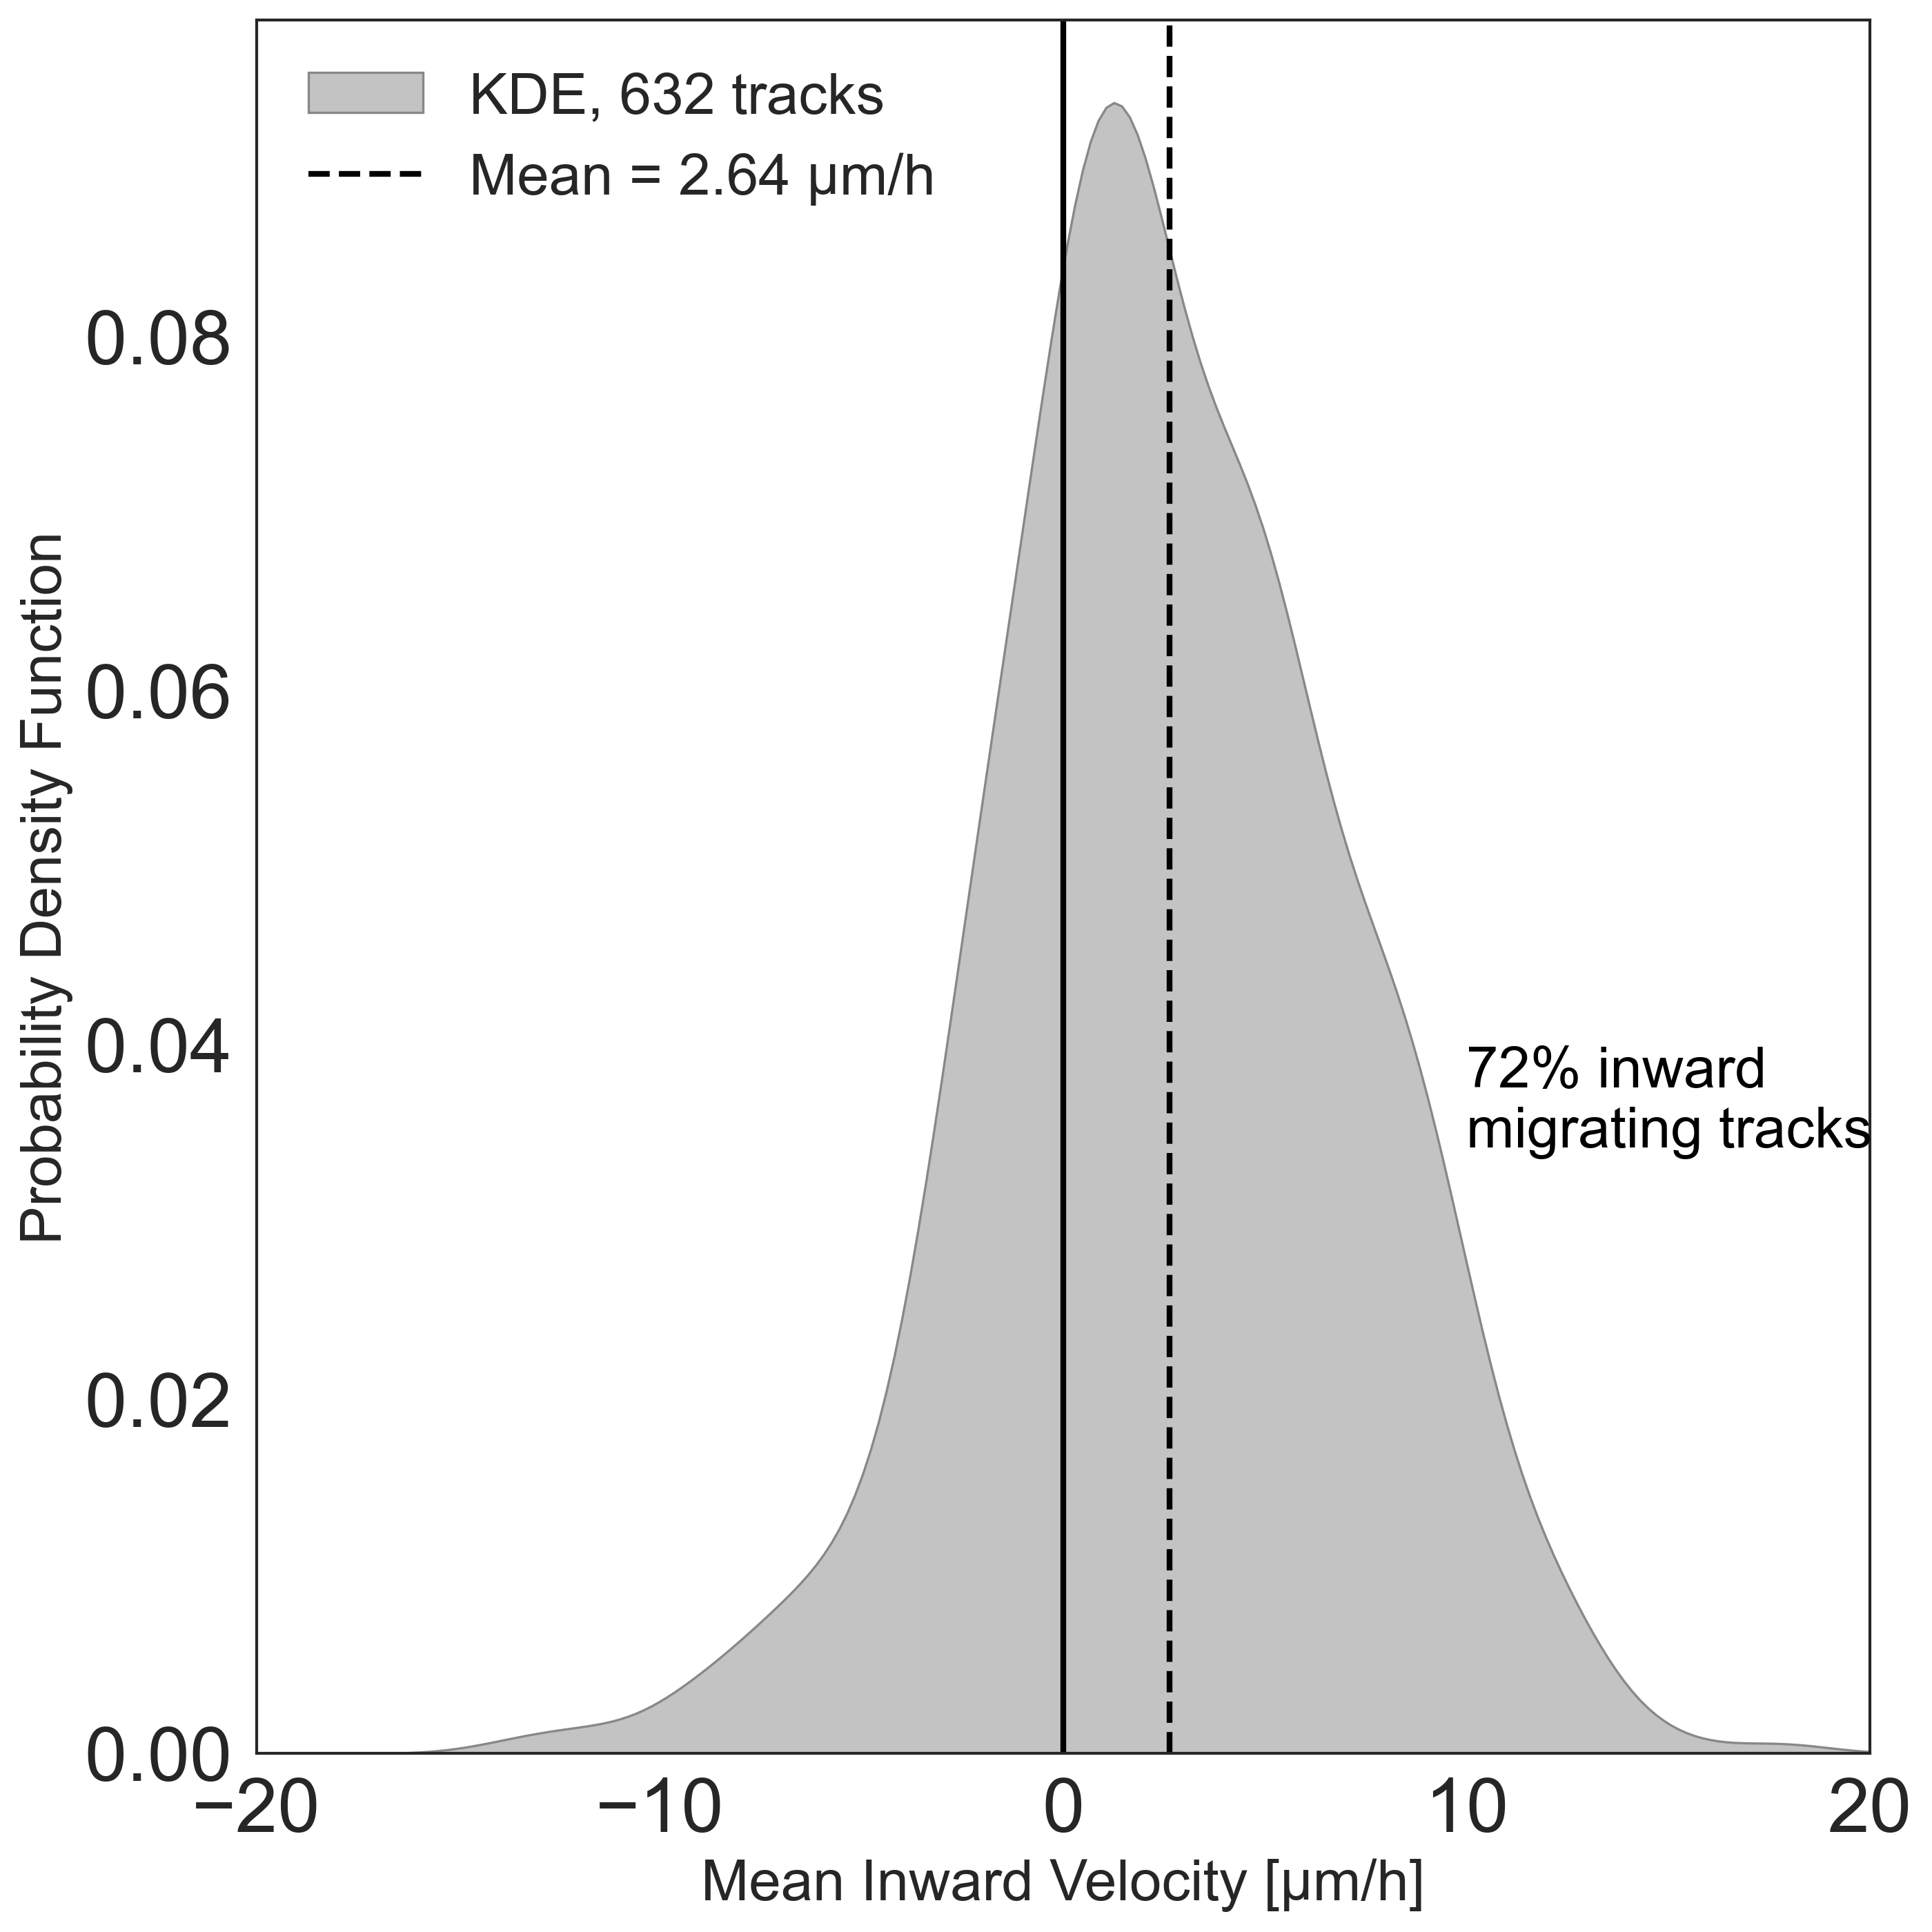

In [94]:
from scipy.stats import gaussian_kde

plt.figure(figsize=(10, 10), dpi=300)

# KDE plot in gray
sns.kdeplot(
    exp_trajectories_df['v_inward_per_hour'],
    label=f'KDE, {exp_trajectories_df.shape[0]} tracks',
    color='#888888',
    fill=True,
    alpha=0.5
)

# Solid black line at zero
plt.axvline(0, color='black', linestyle='-', linewidth=2)

# Dashed black line at the mean
mean_val = exp_trajectories_df['v_inward_per_hour'].mean()
plt.axvline(mean_val, color='black', linestyle='--', linewidth=2, label='Mean = {:.2f} μm/h'.format(mean_val))

# X-axis symmetric [-20, 20]
plt.xlim([-20, 20])

# Y-axis label
plt.ylabel('Probability Density Function', fontsize=20)
plt.xlabel('Mean Inward Velocity [μm/h]', fontsize=20)

# Calculate area under curve to the left of zero
data = exp_trajectories_df['v_inward_per_hour']
kde = gaussian_kde(data)
x_grid = np.linspace(-20, 20, 1000)
cdf_right = kde.integrate_box_1d(0, 20)
percent_right = int(round(cdf_right * 100))

# Annotate left of zero
plt.text(+10, plt.ylim()[1]*0.35, f"{percent_right}% inward\nmigrating tracks", fontsize=20, color='black')

# Legend
plt.legend(loc='upper left', frameon=False, fontsize=20)

plt.tight_layout()
plt.show()

In [95]:
# Step 3: Extract starting positions from experimental data
# Get the first position of each track (x_microns, y_microns)
# convert to a NumPy array so numeric slicing works (avoids DataFrame .__getitem__ indexing errors)

starting_positions_df = exp_data.groupby('track_id').first()[['x_microns', 'y_microns']]
# assume pattern center is the average position of all starting positions 
pattern_center = [starting_positions_df['x_microns'].mean(), starting_positions_df['y_microns'].mean()]
starting_positions_exp = starting_positions_df.values  # shape: (n_tracks, 2)
starting_positions_mapped_to_zero = starting_positions_exp - pattern_center  # center at (0,0)

print(f"\nNumber of starting positions extracted: {len(starting_positions_exp)}")
print(f"Starting positions range:")
print(f"  X: [{starting_positions_exp[:, 0].min():.2f}, {starting_positions_exp[:, 0].max():.2f}]")
print(f"  Y: [{starting_positions_exp[:, 1].min():.2f}, {starting_positions_exp[:, 1].max():.2f}]")
print(f"Pattern center: ({pattern_center[0]:.2f}, {pattern_center[1]:.2f})")
print(f"Mapped starting positions range (centered at zero):")
print(f"  X: [{starting_positions_mapped_to_zero[:, 0].min():.2f}, {starting_positions_mapped_to_zero[:, 0].max():.2f}]")
print(f"  Y: [{starting_positions_mapped_to_zero[:, 1].min():.2f}, {starting_positions_mapped_to_zero[:, 1].max():.2f}]")


Number of starting positions extracted: 632
Starting positions range:
  X: [216.62, 530.85]
  Y: [87.30, 1148.81]
Pattern center: (342.11, 647.39)
Mapped starting positions range (centered at zero):
  X: [-125.49, 188.74]
  Y: [-560.09, 501.42]


In [96]:
# Step 4: Run PRW simulations with experimental starting positions
# Test multiple persistence values to compare with experimental data

persistence_values_bias = [0.0, 0.3, 0.6, 0.9]
n_repeats_bias = 10  # Number of simulation repeats for each persistence value
n_steps_bias = int(exp_data.groupby('track_id').size().mean())  # Average track length in experimental data (cannot take max step beacuse the distance traveled is directly correlated to n_steps even in random walk)
time_step_bias = 5  # minutes

print(f"\nRunning PRW simulations...")
print(f"  Persistence values: {persistence_values_bias}")
print(f"  Repeats per persistence: {n_repeats_bias}")
print(f"  Steps per simulation: {n_steps_bias}")
print(f"  Time step: {time_step_bias} minutes")

# Check if velocity parameters are available
if 'shape' not in globals() or 'loc' not in globals() or 'scale' not in globals():
    print("\nFitting velocity distribution from experimental data...")
    velocity_data_temp = exp_data.groupby('track_id')[['x_microns', 'y_microns']].apply(
        lambda g: np.sqrt(g['x_microns'].diff()**2 + g['y_microns'].diff()**2) / time_step_bias
    ).values
    velocity_data_temp = velocity_data_temp[~np.isnan(velocity_data_temp) & (velocity_data_temp > 0)]
    shape, loc, scale = lognorm.fit(velocity_data_temp, floc=0)
    print(f"  Velocity parameters: shape={shape:.4f}, loc={loc:.4f}, scale={scale:.4f}")

velocity_params_bias = {'shape': shape, 'loc': loc, 'scale': scale}

# Storage for simulation results
sim_results_bias = {
    'persistence': [],
    'repeat': [],
    'v_inward_normalized': [],
    'mean_v_inward': [],
    'std_v_inward': []
}

print("\nRunning simulations...")


Running PRW simulations...
  Persistence values: [0.0, 0.3, 0.6, 0.9]
  Repeats per persistence: 10
  Steps per simulation: 81
  Time step: 5 minutes

Running simulations...


In [97]:
# Reload stadium module to get the distance_from_edge method
import importlib
import stadium
importlib.reload(stadium)
from stadium import VerticalStadium

print("Stadium module reloaded with distance_from_edge method")

Stadium module reloaded with distance_from_edge method


In [98]:
starting_positions_mapped_to_zero

array([[  15.75518836, -391.5665059 ],
       [ -67.46559289,   19.77564254],
       [ -78.30137414,  333.48493941],
       ...,
       [ -65.98481164,  216.60993941],
       [ 121.76706336,  161.39790816],
       [ -23.35471398, -437.54881059]])

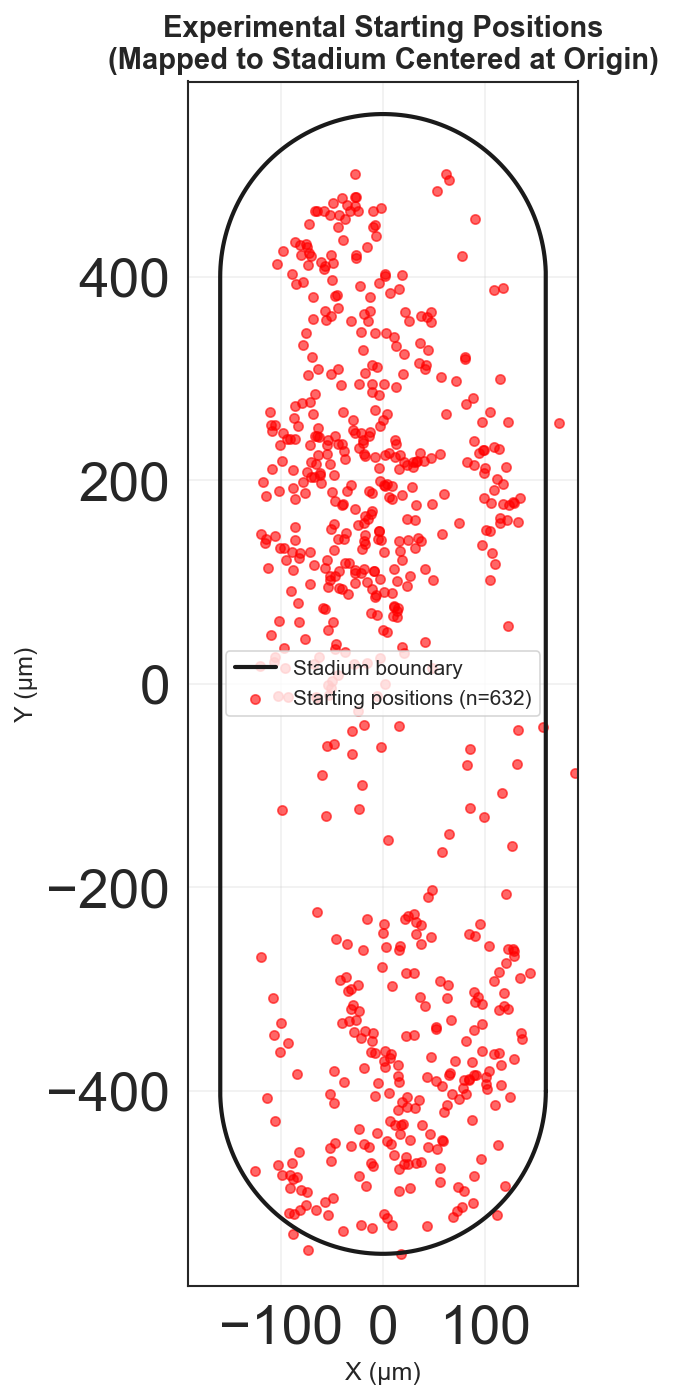

Starting positions verification:
  Total positions: 632
  X range: [-125.5, 188.7]
  Y range: [-560.1, 501.4]
  Mean distance from center: 286.0 μm


In [99]:
# Verify starting positions are correctly set by plotting them in stadium
fig, ax = plt.subplots(1, 1, figsize=(8, 10), dpi=150)

# Draw stadium boundary
stadium_L = 800
stadium_R = 320/2
theta_top = np.linspace(0, np.pi, 100)
theta_bottom = np.linspace(np.pi, 2*np.pi, 100)

x_boundary = []
y_boundary = []
x_boundary.extend([stadium_R, stadium_R])
y_boundary.extend([-stadium_L/2, stadium_L/2])
x_boundary.extend(stadium_R * np.cos(theta_top))
y_boundary.extend(stadium_L/2 + stadium_R * np.sin(theta_top))
x_boundary.extend([-stadium_R, -stadium_R])
y_boundary.extend([stadium_L/2, -stadium_L/2])
x_boundary.extend(stadium_R * np.cos(theta_bottom))
y_boundary.extend(-stadium_L/2 + stadium_R * np.sin(theta_bottom))
x_boundary.append(x_boundary[0])
y_boundary.append(y_boundary[0])

ax.plot(x_boundary, y_boundary, 'k-', linewidth=2, label='Stadium boundary')

# Plot starting positions
ax.scatter(starting_positions_mapped_to_zero[:, 0], 
           starting_positions_mapped_to_zero[:, 1], 
           s=20, c='red', alpha=0.6, label=f'Starting positions (n={len(starting_positions_mapped_to_zero)})')

ax.set_xlim(-stadium_R * 1.2, stadium_R * 1.2)
ax.set_ylim(-stadium_L/2 - stadium_R * 1.2, stadium_L/2 + stadium_R * 1.2)
ax.set_aspect('equal')
ax.set_xlabel('X (μm)', fontsize=12)
ax.set_ylabel('Y (μm)', fontsize=12)
ax.set_title('Experimental Starting Positions\n(Mapped to Stadium Centered at Origin)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Starting positions verification:")
print(f"  Total positions: {len(starting_positions_mapped_to_zero)}")
print(f"  X range: [{starting_positions_mapped_to_zero[:, 0].min():.1f}, {starting_positions_mapped_to_zero[:, 0].max():.1f}]")
print(f"  Y range: [{starting_positions_mapped_to_zero[:, 1].min():.1f}, {starting_positions_mapped_to_zero[:, 1].max():.1f}]")
print(f"  Mean distance from center: {np.mean(np.linalg.norm(starting_positions_mapped_to_zero, axis=1)):.1f} μm")

In [100]:
# Storage for simulation results (now per-trajectory instead of per-step)
sim_results_bias = {
    'persistence': [],
    'repeat': [],
    'cell_id': [],
    'v_inward': [],  # Per-trajectory inward velocity
    'v_inward_normalized': [],
    'initial_distance': [],
    'final_distance': [],
    'trajectory_duration': []
}

print("\nRunning simulations and calculating per-trajectory inward velocities...")

for p_idx, p in enumerate(persistence_values_bias):
    for repeat in range(n_repeats_bias):
        print(f"  Persistence: {p:.1f}, Repeat: {repeat+1}/{n_repeats_bias}", end='\r')
        
        # Create simulation with uniform starting positions (we'll override immediately)
        sim_bias = Simulation(
            n_cells=len(starting_positions_mapped_to_zero),
            time_step=time_step_bias,
            stadium_L=800,
            stadium_R=320/2,
            source_length=1,
            chemotaxis_strength=0.0,  # Pure PRW, no chemotaxis
            repulsion_strength=0.0,
            interaction_radius=0.0,
            velocity_params=velocity_params_bias,
            persistence=p,
            starting_positions='uniform',  # Use uniform as placeholder
            mode='persistent',
            memory_window=None,
            vonmises_params=None
        )
        
        # IMMEDIATELY override with experimental starting positions
        # This must happen BEFORE running the simulation
        for i in range(len(starting_positions_mapped_to_zero)):
            if i < len(sim_bias.cells):
                sim_bias.cells[i].position = starting_positions_mapped_to_zero[i].copy()
        
        # Run simulation
        sim_bias.run(n_steps=n_steps_bias)
        
        # Get trajectory data
        sim_df_bias = sim_bias.get_dataframe()
        
        # Calculate distance from center per whole track
        distances_from_center = []

        id_col = next((c for c in sim_df_bias.columns if c in ('cell', 'cell_id', 'track_id', 'id')), None)
        if id_col is None:
            # create a cell id assuming contiguous blocks per cell (safe since we set n_cells)
            sim_df_bias = sim_df_bias.copy()
            sim_df_bias['cell'] = sim_df_bias.groupby((sim_df_bias['x'].shift() != sim_df_bias['x']).cumsum()).ngroup()
            id_col = 'cell'

        # compute distance from center (simulation was started centered at (0,0) when using starting_positions_mapped_to_zero)
        sim_df_bias['distance_from_center'] = np.sqrt(sim_df_bias['x']**2 + sim_df_bias['y']**2)

        # iterate over trajectories (cells)
        for cid, group in sim_df_bias.groupby(id_col):
            group = group.sort_values(by='step') if 'step' in group.columns else group.sort_index()
            if len(group) < 2:
                continue

            dist_initial = group['distance_from_center'].iloc[0]
            dist_final = group['distance_from_center'].iloc[-1]
            n_steps_track = len(group) - 1
            duration_min = n_steps_track * time_step_bias  # minutes

            # inward velocity: positive -> moving toward center
            # i.e. if distance_from_center decreased, that's positive
            diff_distance = dist_final - dist_initial
            v_inward = -diff_distance / duration_min if duration_min > 0 else 0

            # normalize by experimental std
            v_inward_normalized = v_inward / sigma_v_inward

            # store
            sim_results_bias['persistence'].append(p)
            sim_results_bias['repeat'].append(repeat)
            sim_results_bias['cell_id'].append(cid)
            sim_results_bias['v_inward'].append(v_inward)
            sim_results_bias['v_inward_normalized'].append(v_inward_normalized)
            sim_results_bias['initial_distance'].append(dist_initial)
            sim_results_bias['final_distance'].append(dist_final)
            sim_results_bias['trajectory_duration'].append(duration_min)

print("\nSimulations complete!                                        ")

# Convert to DataFrame
sim_results_bias_df = pd.DataFrame(sim_results_bias)

print(f"\nTotal simulation trajectories: {len(sim_results_bias_df)}")
print(f"Average trajectory duration: {sim_results_bias_df['trajectory_duration'].mean():.1f} minutes")
print(f"Average initial distance from center: {sim_results_bias_df['initial_distance'].mean():.1f} μm")
print(f"Average final distance from center: {sim_results_bias_df['final_distance'].mean():.1f} μm")
print(f"\nPer persistence:")
for p in persistence_values_bias:
    subset = sim_results_bias_df[sim_results_bias_df['persistence'] == p]
    n_tracks = len(subset)
    avg_init_dist = subset['initial_distance'].mean()
    print(f"  p={p:.1f}: {n_tracks} trajectories, avg initial dist = {avg_init_dist:.1f} μm")


Running simulations and calculating per-trajectory inward velocities...
Step 25/81 completedRepeat: 1/10
Step 50/81 completed
Step 75/81 completed
Simulation completed: 81 steps
Step 25/81 completedRepeat: 2/10
Step 50/81 completed
Step 75/81 completed
Simulation completed: 81 steps
Step 25/81 completedRepeat: 3/10
Step 50/81 completed
Step 75/81 completed
Simulation completed: 81 steps
Step 25/81 completedRepeat: 4/10
Step 50/81 completed
Step 75/81 completed
Simulation completed: 81 steps
Step 25/81 completedRepeat: 5/10
Step 50/81 completed
Step 75/81 completed
Simulation completed: 81 steps
Step 25/81 completedRepeat: 6/10
Step 50/81 completed
Step 75/81 completed
Simulation completed: 81 steps
Step 25/81 completedRepeat: 7/10
Step 50/81 completed
Step 75/81 completed
Simulation completed: 81 steps
Step 25/81 completedRepeat: 8/10
Step 50/81 completed
Step 75/81 completed
Simulation completed: 81 steps
Step 25/81 completedRepeat: 9/10
Step 50/81 completed
Step 75/81 completed
Simu

<Figure size 600x600 with 0 Axes>

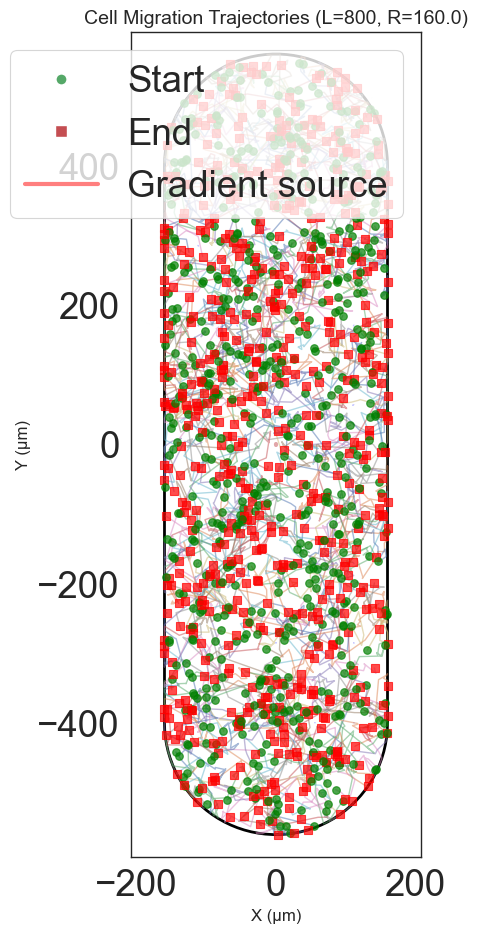

(<Figure size 600x1000 with 1 Axes>,
 <Axes: title={'center': 'Cell Migration Trajectories (L=800, R=160.0)'}, xlabel='X (μm)', ylabel='Y (μm)'>)

In [101]:
# plot track from last simulation as a quick check
plt.figure(figsize=(6,6))
plot_trajectories(sim_bias)

Step 25/100 completed
Step 50/100 completed
Step 75/100 completed
Step 100/100 completed
Simulation completed: 100 steps
Could not save animation: [WinError 2] The system cannot find the file specified


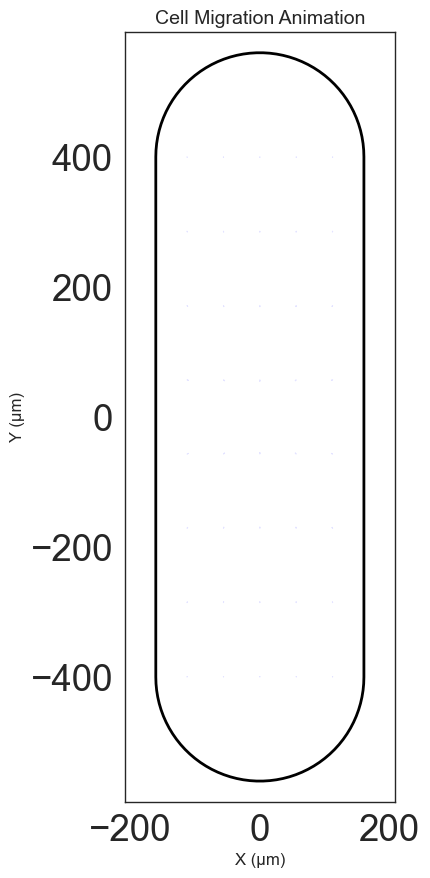

In [102]:
# animation for persistence = 0.0
sim_bias_zero = Simulation(
    n_cells=50,
    time_step=5,
    stadium_L=800,
    stadium_R=320/2,
    source_length=1,
    chemotaxis_strength=0.0,
    repulsion_strength=0.0,
    interaction_radius=0.0,
    velocity_params=velocity_params_bias,
    persistence=0.0,
    starting_positions='uniform',
    mode='persistent',
    memory_window=None,
    vonmises_params=None
)

# Override starting positions
for i in range(50):
    if i < len(starting_positions_mapped_to_zero):
        sim_bias_zero.cells[i].position = starting_positions_mapped_to_zero[i].copy()
sim_bias_zero.run(n_steps=100)
anim = create_animation(sim_bias_zero, interval=1, save_path='PRW_p0_startingPositions.avi')

In [103]:
# Step 5: Compare distributions - Statistical summary (PER-TRAJECTORY)
print("=" * 70)
print("STATISTICAL COMPARISON: Per-Trajectory Inward Velocities")
print("=" * 70)

# Experimental stats
print("\nEXPERIMENTAL DATA:")
print(f"  N trajectories: {len(exp_trajectories_df)}")
print(f"  Mean (normalized): {exp_trajectories_df['v_inward_normalized'].mean():.4f}")
print(f"  Std (normalized): {exp_trajectories_df['v_inward_normalized'].std():.4f}")
print(f"  Median (normalized): {exp_trajectories_df['v_inward_normalized'].median():.4f}")
print(f"  Skewness: {exp_trajectories_df['v_inward_normalized'].skew():.4f}")

print("\n" + "-" * 70)
print("SIMULATION RESULTS (by persistence):")
print("-" * 70)

for p in persistence_values_bias:
    sim_subset = sim_results_bias_df[sim_results_bias_df['persistence'] == p]
    print(f"\nPersistence = {p:.1f}:")
    print(f"  N trajectories: {len(sim_subset)}")
    print(f"  Mean (normalized): {sim_subset['v_inward_normalized'].mean():.4f}")
    print(f"  Std (normalized): {sim_subset['v_inward_normalized'].std():.4f}")
    print(f"  Median (normalized): {sim_subset['v_inward_normalized'].median():.4f}")
    print(f"  Skewness: {sim_subset['v_inward_normalized'].skew():.4f}")
    
    # Difference from experimental
    mean_diff = sim_subset['v_inward_normalized'].mean() - exp_trajectories_df['v_inward_normalized'].mean()
    print(f"  Difference from exp (mean): {mean_diff:+.4f}")

print("\n" + "=" * 70)

STATISTICAL COMPARISON: Per-Trajectory Inward Velocities

EXPERIMENTAL DATA:
  N trajectories: 632
  Mean (normalized): 0.5864
  Std (normalized): 1.0000
  Median (normalized): 0.4944
  Skewness: -0.0625

----------------------------------------------------------------------
SIMULATION RESULTS (by persistence):
----------------------------------------------------------------------

Persistence = 0.0:
  N trajectories: 6320
  Mean (normalized): -0.0048
  Std (normalized): 0.5238
  Median (normalized): -0.0075
  Skewness: -0.0077
  Difference from exp (mean): -0.5912

Persistence = 0.3:
  N trajectories: 6320
  Mean (normalized): -0.0123
  Std (normalized): 0.6275
  Median (normalized): -0.0065
  Skewness: -0.0223
  Difference from exp (mean): -0.5987

Persistence = 0.6:
  N trajectories: 6320
  Mean (normalized): -0.0017
  Std (normalized): 0.8410
  Median (normalized): 0.0023
  Skewness: -0.0397
  Difference from exp (mean): -0.5881

Persistence = 0.9:
  N trajectories: 6320
  Mean (no

In [104]:
# Create a 'movie' column by splitting the track_id string on '_' and taking the first part.
# Use .astype(str) and pandas string methods so this works for numeric or string track_id values.
exp_trajectories_df['movie'] = exp_trajectories_df['track_id'].astype(str).str.split('_').str[4].str.split('.').str[0]

In [105]:
# summary statistics per movie
exp_movie_summary = exp_trajectories_df.groupby('movie')['v_inward_normalized'] \
    .agg(['mean', 'std', 'count']).reset_index().rename(columns={'mean': 'mean_v_inward_norm', 'std': 'std_v_inward_norm'})
print("\nExperimental per-movie summary:")
print(exp_movie_summary)

# summary statistics per persistence in simulations
sim_persistence_summary = sim_results_bias_df.groupby(['persistence', 'repeat'])['v_inward_normalized'] \
    .agg(['mean', 'std', 'count']).reset_index().rename(columns={'mean': 'mean_v_inward_norm', 'std': 'std_v_inward_norm'})
print("\nSimulation per-persistence per-repeat summary:")
print(sim_persistence_summary)


Experimental per-movie summary:
   movie  mean_v_inward_norm  std_v_inward_norm  count
0     01            0.534491           0.986297     51
1     02            0.471540           0.945460     79
2     03            0.572022           1.021282     62
3     04            0.543937           0.674711     28
4     05            0.911148           1.124814     67
5     06            0.537172           0.988862    146
6     07            0.716000           0.735164     40
7     08            0.588370           0.806317     22
8     09            0.234220           0.992149     34
9     10            0.909293           1.106393     47
10    11            0.421695           1.111388     56

Simulation per-persistence per-repeat summary:
    persistence  repeat  mean_v_inward_norm  std_v_inward_norm  count
0           0.0       0            0.008440           0.524289    632
1           0.0       1            0.009667           0.537330    632
2           0.0       2           -0.035275      

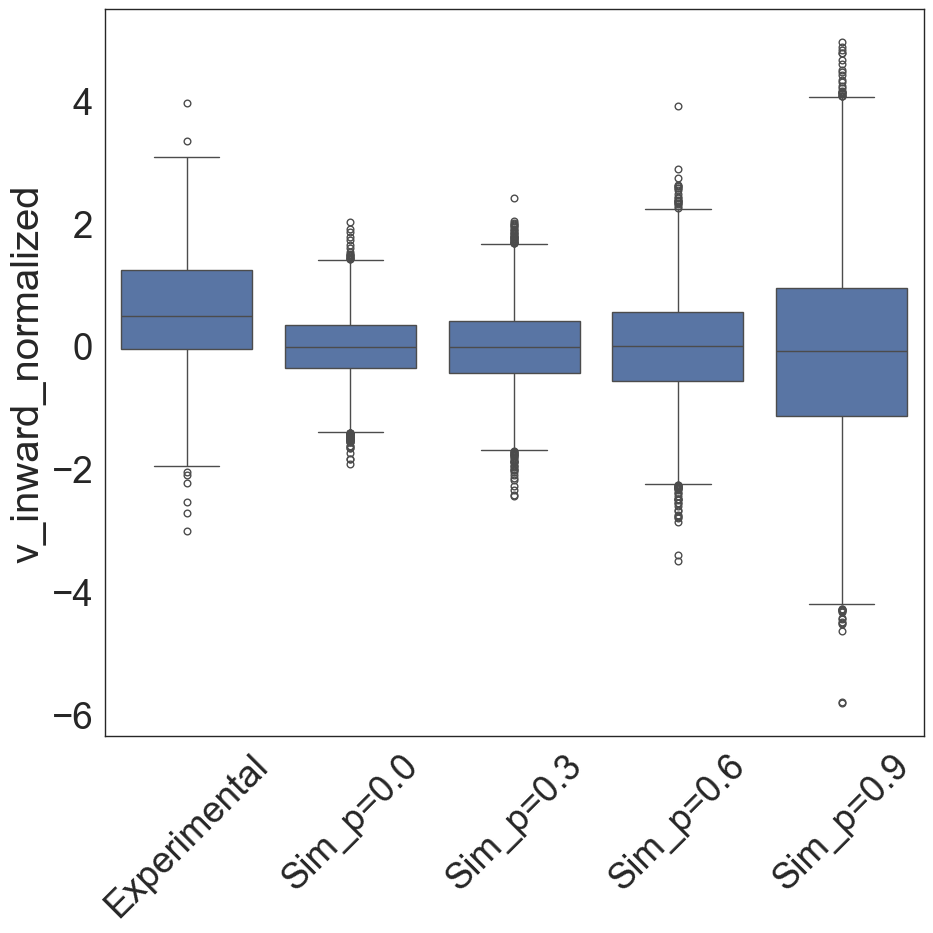


Statistical Tests (Mann-Whitney U):

Persistence 0.0:
  U-statistic: 2804135.00
  p-value: 0.0000
  Effect size: -0.404
  Exp mean: 0.586, Sim mean: -0.005

Persistence 0.3:
  U-statistic: 2779402.00
  p-value: 0.0000
  Effect size: -0.392
  Exp mean: 0.586, Sim mean: -0.012

Persistence 0.6:
  U-statistic: 2694770.00
  p-value: 0.0000
  Effect size: -0.349
  Exp mean: 0.586, Sim mean: -0.002

Persistence 0.9:
  U-statistic: 2568199.00
  p-value: 0.0000
  Effect size: -0.286
  Exp mean: 0.586, Sim mean: -0.078

Bonferroni-corrected α = 0.0125


In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Prepare data for plotting
# Add a label to experimental data
exp_trajectories_df['group'] = 'Experimental'

# Add persistence as string for simulations
sim_results_bias_df['group'] = 'Sim_p=' + sim_results_bias_df['persistence'].astype(str)

# Combine for boxplot
plot_df = pd.concat([
    exp_trajectories_df[['v_inward_normalized', 'group']],
    sim_results_bias_df[['v_inward_normalized', 'group']]
])

# Create boxplot
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(data=plot_df, x='group', y='v_inward_normalized', ax=ax)
ax.set_ylabel('v_inward_normalized')
ax.set_xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistical tests: Compare experimental to each persistence level
exp_data = exp_trajectories_df['v_inward_normalized'].values

print("\nStatistical Tests (Mann-Whitney U):")
for persistence in sim_results_bias_df['persistence'].unique():
    sim_data = sim_results_bias_df[sim_results_bias_df['persistence'] == persistence]['v_inward_normalized'].values
    
    # Mann-Whitney U (non-parametric, no normality assumption)
    statistic, pvalue = stats.mannwhitneyu(exp_data, sim_data, alternative='two-sided')
    
    # Effect size (rank-biserial correlation)
    effect_size = 1 - (2*statistic) / (len(exp_data) * len(sim_data))
    
    print(f"\nPersistence {persistence}:")
    print(f"  U-statistic: {statistic:.2f}")
    print(f"  p-value: {pvalue:.4f}")
    print(f"  Effect size: {effect_size:.3f}")
    print(f"  Exp mean: {exp_data.mean():.3f}, Sim mean: {sim_data.mean():.3f}")

# Bonferroni correction for multiple comparisons
n_tests = len(sim_results_bias_df['persistence'].unique())
print(f"\nBonferroni-corrected α = {0.05/n_tests:.4f}")


Statistical Comparisons (Mann-Whitney U):
Persistence 0.0: p=0.0000 ***
Persistence 0.3: p=0.0000 ***
Persistence 0.6: p=0.0000 ***
Persistence 0.9: p=0.0000 ***


C:\Users\davidzi\AppData\Local\Temp\ipykernel_95900\2399489225.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x='group', y='v_inward_normalized',
C:\Users\davidzi\AppData\Local\Temp\ipykernel_95900\2399489225.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)


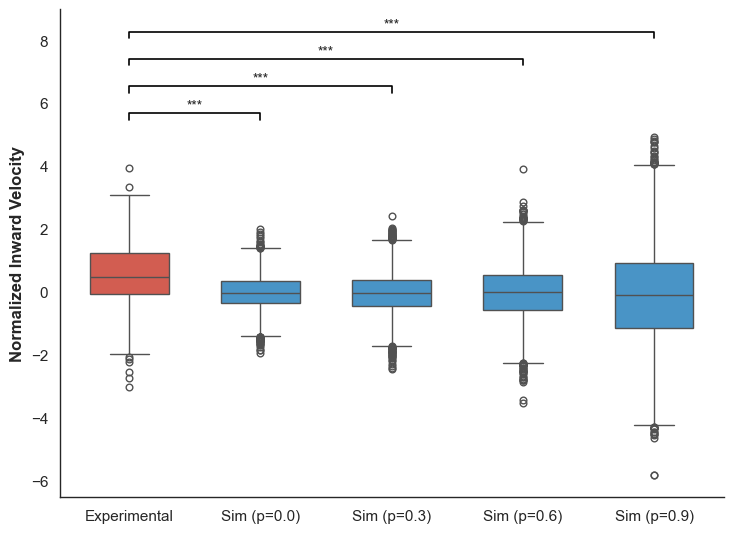


Bonferroni-corrected α = 0.0125


In [107]:
# Prepare data
exp_trajectories_df['group'] = 'Experimental'
exp_trajectories_df['order'] = 0

sim_results_bias_df['group'] = sim_results_bias_df['persistence'].astype(str)
sim_results_bias_df['order'] = sim_results_bias_df['persistence'] + 1

plot_df = pd.concat([
    exp_trajectories_df[['v_inward_normalized', 'group', 'order']],
    sim_results_bias_df[['v_inward_normalized', 'group', 'order']]
])
plot_df = plot_df.sort_values('order')

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Define colors
exp_color = '#E74C3C'  # Red
sim_colors = ['#3498DB', '#3498DB', '#3498DB', '#3498DB']  # Blues/greens for sims
colors = [exp_color] + sim_colors

# Create boxplot
sns.boxplot(data=plot_df, x='group', y='v_inward_normalized', 
            palette=colors, ax=ax, width=0.6)

# Style improvements
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Normalized Inward Velocity', fontsize=12, fontweight='bold')
ax.set_xlabel('')
ax.tick_params(axis='both', labelsize=11)

# Statistical tests and annotations
exp_data = exp_trajectories_df['v_inward_normalized'].values
persistence_levels = sorted(sim_results_bias_df['persistence'].unique())

y_max = plot_df['v_inward_normalized'].max()
y_range = plot_df['v_inward_normalized'].max() - plot_df['v_inward_normalized'].min()
y_offset = y_max + 0.05 * y_range

print("\nStatistical Comparisons (Mann-Whitney U):")
for i, persistence in enumerate(persistence_levels):
    sim_data = sim_results_bias_df[sim_results_bias_df['persistence'] == persistence]['v_inward_normalized'].values
    
    statistic, pvalue = stats.mannwhitneyu(exp_data, sim_data, alternative='two-sided')
    
    # Determine significance level
    if pvalue < 0.001:
        sig_label = '***'
    elif pvalue < 0.01:
        sig_label = '**'
    elif pvalue < 0.05:
        sig_label = '*'
    else:
        sig_label = 'n.s.'
    
    print(f"Persistence {persistence}: p={pvalue:.4f} {sig_label}")
    
    # Add significance annotation
    x1, x2 = 0, i + 1
    y = y_offset + i * 0.08 * y_range
    h = 0.02 * y_range
    
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.2, c='black')
    ax.text((x1+x2)/2, y+h, sig_label, ha='center', va='bottom', fontsize=10)

# Update x-axis labels
labels = ['Experimental'] + [f'Sim (p={p})' for p in persistence_levels]
ax.set_xticklabels(labels, rotation=0)

plt.tight_layout()
plt.savefig('boxplot_with_stats.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
n_tests = len(persistence_levels)
print(f"\nBonferroni-corrected α = {0.05/n_tests:.4f}")

In [108]:
from scipy import stats

exp_data = exp_trajectories_df['v_inward_normalized'].values

print("\nEffect Sizes (Cohen's d):")
for persistence in sorted(sim_results_bias_df['persistence'].unique()):
    sim_data = sim_results_bias_df[sim_results_bias_df['persistence'] == persistence]['v_inward_normalized'].values
    
    # Mann-Whitney U test
    statistic, pvalue = stats.mannwhitneyu(exp_data, sim_data)
    
    # Cohen's d (standardized mean difference)
    mean_diff = exp_data.mean() - sim_data.mean()
    pooled_std = np.sqrt((exp_data.std()**2 + sim_data.std()**2) / 2)
    cohens_d = mean_diff / pooled_std
    
    print(f"p={persistence}: mean_diff={mean_diff:.3f}, Cohen's d={cohens_d:.3f}, p={pvalue:.4f}")


Effect Sizes (Cohen's d):
p=0.0: mean_diff=0.591, Cohen's d=0.741, p=0.0000
p=0.3: mean_diff=0.599, Cohen's d=0.718, p=0.0000
p=0.6: mean_diff=0.588, Cohen's d=0.637, p=0.0000
p=0.9: mean_diff=0.664, Cohen's d=0.510, p=0.0000


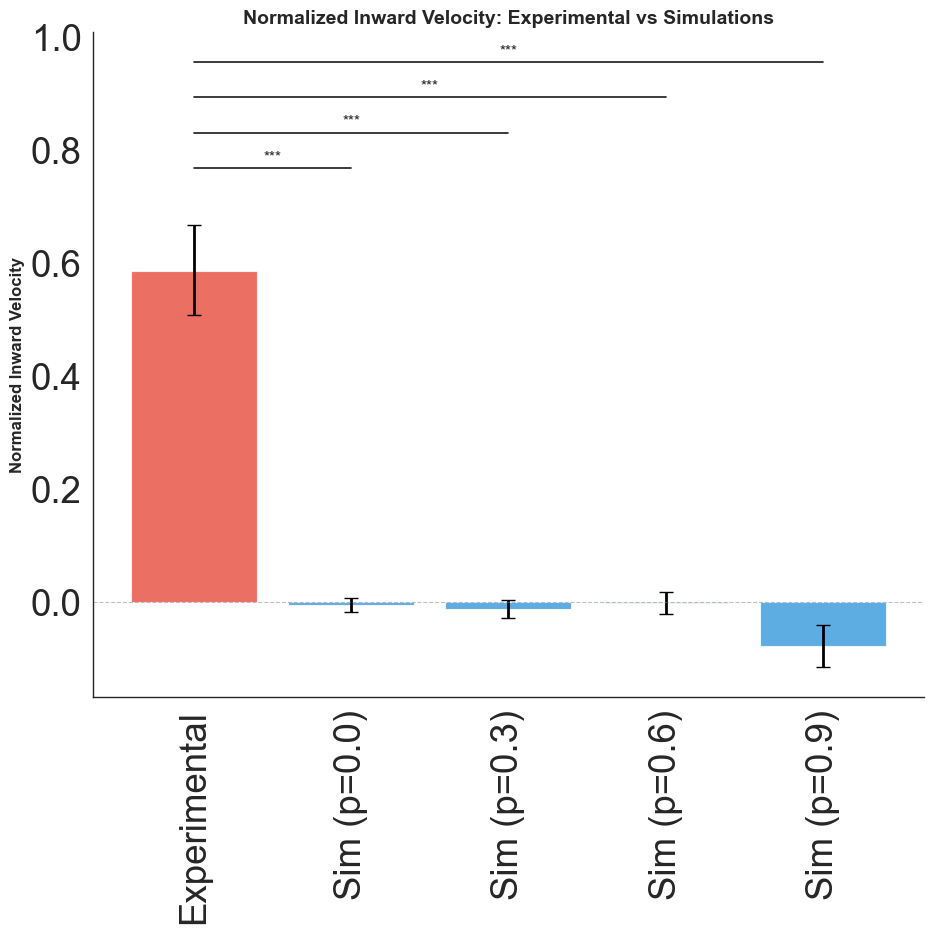

In [109]:
# Calculate means and confidence intervals
def bootstrap_ci(data, n_boot=1000):
    means = [np.random.choice(data, len(data), replace=True).mean() 
             for _ in range(n_boot)]
    return np.percentile(means, [2.5, 97.5])

# Prepare summary data
exp_data = exp_trajectories_df['v_inward_normalized'].values
results = [{'group': 'Experimental', 'mean': exp_data.mean(), 
            'ci_low': bootstrap_ci(exp_data)[0], 
            'ci_high': bootstrap_ci(exp_data)[1],
            'color': '#E74C3C', 'order': 0}]

sim_colors = ['#3498DB', '#3498DB', '#3498DB', '#3498DB']
for i, persistence in enumerate(sorted(sim_results_bias_df['persistence'].unique())):
    sim_data = sim_results_bias_df[sim_results_bias_df['persistence'] == persistence]['v_inward_normalized'].values
    ci = bootstrap_ci(sim_data)
    results.append({
        'group': f'Sim (p={persistence})',
        'mean': sim_data.mean(),
        'ci_low': ci[0],
        'ci_high': ci[1],
        'color': sim_colors[i],
        'order': i+1
    })

results_df = pd.DataFrame(results)
results_df['ci_err_low'] = results_df['mean'] - results_df['ci_low']
results_df['ci_err_high'] = results_df['ci_high'] - results_df['mean']

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))

# Bar plot with 95% CI
x_pos = np.arange(len(results_df))
bars = ax.bar(x_pos, results_df['mean'], 
              yerr=[results_df['ci_err_low'], results_df['ci_err_high']],
              color=results_df['color'], alpha=0.8, 
              error_kw={'linewidth': 2, 'ecolor': 'black', 'capsize': 5})

# Add significance annotations
y_max = results_df['ci_high'].max()
y_range = y_max - results_df['ci_low'].min()
for i in range(1, len(results_df)):
    y = y_max + (0.05 + i*0.08) * y_range
    ax.plot([0, i], [y, y], 'k-', linewidth=1.2)
    ax.text(i/2, y+0.01*y_range, '***', ha='center', va='bottom', fontsize=11)

ax.set_title('Normalized Inward Velocity: Experimental vs Simulations', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_df['group'], rotation=90)
ax.set_ylabel('Normalized Inward Velocity', fontsize=12, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
plt.tight_layout()
plt.show()

Sample sizes: persistence
0.0     10
0.3     10
0.6     10
0.9     10
data    11
dtype: int64

Summary stats:
             count      mean       std       min       25%       50%  \
persistence                                                            
0.0           10.0 -0.009420  0.035291 -0.066392 -0.026771 -0.019870   
0.3           10.0 -0.019617  0.046495 -0.076855 -0.054158 -0.023319   
0.6           10.0 -0.002346  0.018771 -0.027596 -0.014078 -0.002058   
0.9           10.0 -0.050512  0.044617 -0.137463 -0.078503 -0.037164   
data          11.0  0.627381  0.219950  0.236073  0.520329  0.560102   

                  75%       max  
persistence                      
0.0          0.017518  0.046449  
0.3         -0.002993  0.062064  
0.6          0.002877  0.041721  
0.9         -0.012672 -0.007634  
data         0.808110  0.973932  

=== ANOVA Results ===
                  sum_sq    df          F        PR(>F)
C(persistence)  3.634621   4.0  78.049487  6.633998e-20
Residual    

C:\Users\davidzi\AppData\Local\Temp\ipykernel_95900\4293603081.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='persistence', y='z_score', data=df, palette=color_map,


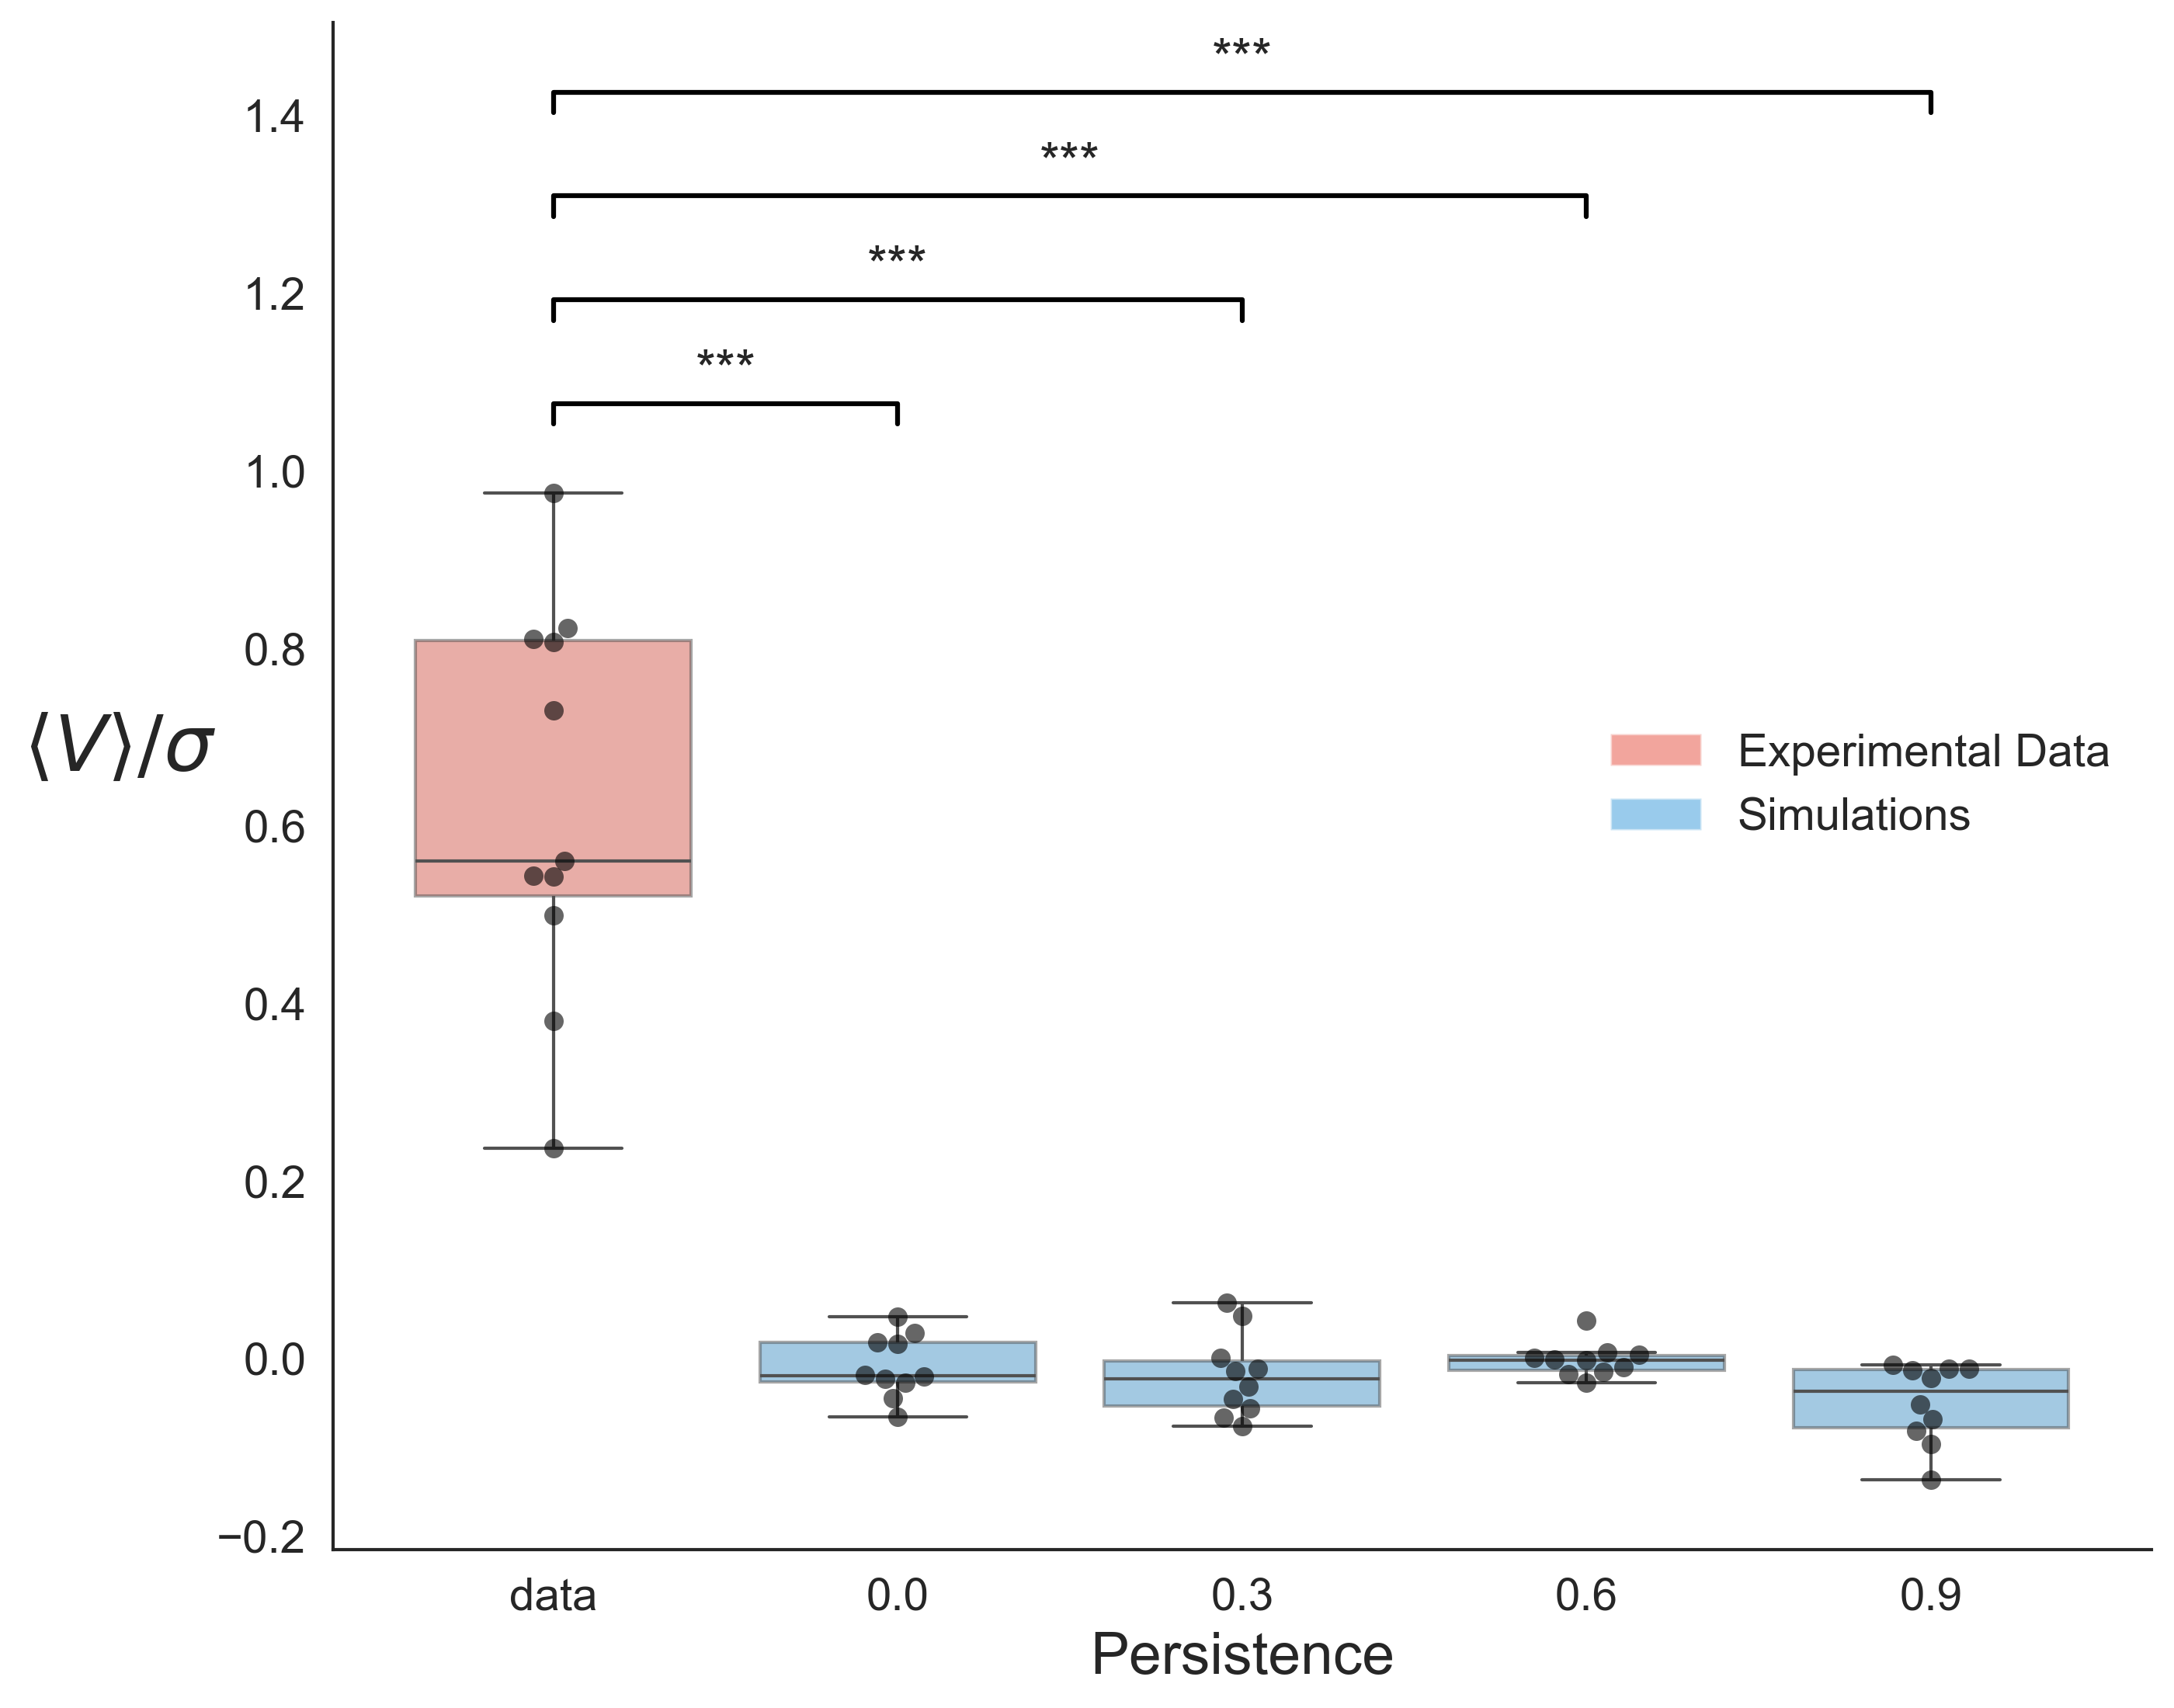

In [126]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# --- Step 1: Calculate summary statistics per movie/repeat ---
# Experimental: one summary per movie
exp_summary = exp_trajectories_df.groupby('movie')['v_inward_normalized'].agg(['mean', 'std']).reset_index()
exp_summary['z_score'] = exp_summary['mean'] / exp_summary['std']  # Coefficient of variation
exp_summary['persistence'] = 'data'

# Simulations: one summary per persistence-repeat combination
sim_summary = sim_results_bias_df.groupby(['persistence', 'repeat'])['v_inward_normalized'].agg(['mean', 'std']).reset_index()
sim_summary['z_score'] = sim_summary['mean'] / sim_summary['std']
sim_summary['persistence'] = sim_summary['persistence'].astype(str)

# Combine
df = pd.concat([
    exp_summary[['persistence', 'mean', 'std', 'z_score']],
    sim_summary[['persistence', 'mean', 'std', 'z_score']]
], ignore_index=True)

print(f"Sample sizes: {df.groupby('persistence').size()}")
print(f"\nSummary stats:\n{df.groupby('persistence')['z_score'].describe()}")

# --- Step 2: ANOVA ---
# Use a valid column name (z_score) in the formula to avoid patsy parsing issues
model = ols('z_score ~ C(persistence)', data=df).fit() # OLS model
anova_table = sm.stats.anova_lm(model, typ=2)
print("\n=== ANOVA Results ===")
print(anova_table)

# Effect sizes
ss_between = anova_table['sum_sq']['C(persistence)']
ss_within = anova_table['sum_sq']['Residual']
df_between = anova_table['df']['C(persistence)']
df_within = anova_table['df']['Residual']
ms_within = ss_within / df_within
eta_sq = ss_between / (ss_between + ss_within)
omega_sq = (ss_between - (df_between * ms_within)) / (ss_between + ss_within + ms_within)
print(f"\nEffect sizes - Eta²: {eta_sq:.4f}, Omega²: {omega_sq:.4f}")

# --- Step 3: Tukey HSD post-hoc ---
tukey = pairwise_tukeyhsd(endog=df['z_score'], groups=df['persistence'], alpha=0.05)
print("\n=== Tukey HSD ===")
print(tukey)

tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], 
                        columns=tukey._results_table.data[0])

# --- Step 4: Plot ---
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

# Define colors
color_map = {
    "data": '#E74C3C',  # Red for experimental
    "0.0": '#3498DB',   # Blue for simulations
    "0.3": '#3498DB',
    "0.6": '#3498DB',
    "0.9": '#3498DB'
}

# Boxplot with swarmplot
order = ['data', '0.0', '0.3', '0.6', '0.9']
sns.boxplot(x='persistence', y='z_score', data=df, palette=color_map, 
            order=order, showfliers=False, boxprops={'alpha': 0.5}, ax=ax)
sns.swarmplot(x='persistence', y='z_score', data=df, color='black', 
              order=order, alpha=0.6, size=6, ax=ax)

# Labels
ax.set_ylabel(r"$\langle V \rangle / \sigma$", fontsize=24, rotation=0, labelpad=30)
ax.set_xlabel("Persistence", fontsize=18)
ax.tick_params(labelsize=14)

# Significance annotations - only pairs involving 'data'
sig_pairs = []
for _, row in tukey_df.iterrows():
    if ('data' in [row['group1'], row['group2']]) and row['reject']:
        sig_pairs.append((row['group1'], row['group2'], row['p-adj']))

def p_to_stars(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return 'ns'

# Position mapping
positions = {cat: i for i, cat in enumerate(order)}
y_max = df['z_score'].max()
h = y_max * 0.08
offset = 0

for g1, g2, pval in sig_pairs:
    x1, x2 = positions[g1], positions[g2]
    y = y_max + offset + h
    stars = p_to_stars(pval)
    
    ax.plot([x1, x1, x2, x2], [y, y+h*0.3, y+h*0.3, y], lw=1.5, color='black')
    ax.text((x1+x2)*0.5, y+h*0.4, stars, ha='center', va='bottom', fontsize=16)
    
    offset += h * 1.5

# Legend
handles = [
    plt.Rectangle((0, 0), 1, 1, facecolor='#E74C3C', alpha=0.5, label='Experimental Data'),
    plt.Rectangle((0, 0), 1, 1, facecolor='#3498DB', alpha=0.5, label='Simulations')
]
ax.legend(handles=handles, frameon=False, fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
# plt.savefig('hierarchical_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()